<a href="https://colab.research.google.com/github/michiWS1920/nfl_data/blob/michi/playingaround.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
library(tidyverse)
library(ggplot2)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
install.packages("ggrepel")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
library(ggrepel)

In [ ]:
install.packages("ggridges")

In [ ]:
library(ggridges)

In [6]:
install.packages("ggforce")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘tweenr’, ‘polyclip’, ‘RcppEigen’




In [7]:
library(ggforce)

In [4]:
install.packages("scales")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘farver’




In [5]:
library(scales)


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




In [2]:
install.packages("networkD3")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘igraph’




In [3]:
library(networkD3)

In [ ]:
first <- 2009 
last <- 2019 

datalist = list()
for (yr in first:last) {
    pbp <- read_csv(url(paste0("https://github.com/ryurko/nflscrapR-data/raw/master/play_by_play_data/regular_season/reg_pbp_", yr, ".csv"))) #read every play by play data
    games <- read_csv(url(paste0("https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/games_data/regular_season/reg_games_", yr, ".csv"))) #read game data including score/ week etc.
    pbp <- pbp %>% 
      inner_join(games %>% distinct(game_id, week, season)) %>% #join the two
      select(-fumble_recovery_2_yards, -blocked_player_id, -fumble_recovery_2_player_id) # throw some variables out that are inconsistent in format over the seasons
    datalist[[yr]] <- pbp 
}

pbp_all <- dplyr::bind_rows(datalist)

In [ ]:
# Change teamnames for teams that changed their names in the last 10 seasons - to have consistent data
pbp_all <- pbp_all %>% 
	mutate_at(vars(home_team, away_team, posteam, defteam), funs(case_when(
            . %in% "JAX" ~ "JAC",
            . %in% "STL" ~ "LA",
            . %in% "SD" ~ "LAC",
            TRUE ~ .
        ))) 

In [4]:
#saveRDS(pbp_all, file="NFLdata.rds")
pbp_all <- readRDS("NFLdata.rds")

In [5]:
# cleaning for further analysis
pbp_all_rp <- pbp_all %>%
      filter(!is.na(epa), !is.na(posteam), play_type=="no_play" | play_type=="pass" | play_type=="run") %>% #filter out certain NA values, only show three play_types
	mutate( #create new columns that indicates if the play was a pass or rush - this is done by parsing the description of the play (certain keywords are perfect indicators)
	pass = if_else(str_detect(desc, "( pass)|(sacked)|(scramble)"), 1, 0), #
	rush = if_else(str_detect(desc, "(left end)|(left tackle)|(left guard)|(up the middle)|(right guard)|(right tackle)|(right end)") & pass == 0, 1, 0),
	success = ifelse(epa>0, 1 , 0),
	passer_player_name = ifelse(play_type == "no_play" & pass == 1, #create new column that parses the player_name depending on the type of play (pass / receiver / rusher)
              str_extract(desc, "(?<=\\s)[A-Z][a-z]*\\.\\s?[A-Z][A-z]+(\\s(I{2,3})|(IV))?(?=\\s((pass)|(sack)|(scramble)))"),
              passer_player_name),
        receiver_player_name = ifelse(play_type == "no_play" & str_detect(desc, "pass"), 
              str_extract(desc, "(?<=to\\s)[A-Z][a-z]*\\.\\s?[A-Z][A-z]+(\\s(I{2,3})|(IV))?"),
              receiver_player_name),
        rusher_player_name = ifelse(play_type == "no_play" & rush == 1, 
              str_extract(desc, "(?<=\\s)[A-Z][a-z]*\\.\\s?[A-Z][A-z]+(\\s(I{2,3})|(IV))?(?=\\s((left end)|(left tackle)|(left guard)|		      (up the middle)|(right guard)|(right tackle)|(right end)))"),
              rusher_player_name),
	name = ifelse(!is.na(passer_player_name), passer_player_name, rusher_player_name),
	yards_gained=ifelse(play_type=="no_play",NA,yards_gained), # filter out NA for yards_gained
	play=1
	) 

In [22]:
pbp_all_rp %>%
select(play_type) %>%
head()

play_type
<chr>
pass
run
pass
run
pass
run


Problem is Timeouts are in noplay, have to filter them out


In [ ]:
pbp_all_rp %>%
group_by(season) %>%
filter(play_type== "no_play", str_detect(desc, "(Timeout)")) %>%
select(desc)

Adding missing grouping variables: `season`



season,desc
<dbl>,<chr>
2009,Timeout #1 by PIT at 01:29.
2009,Timeout #1 by TEN at 00:54.
2009,Timeout #2 by PIT at 00:27.
2009,Timeout #3 by PIT at 00:07.
2009,Timeout #1 by PIT at 01:03.
2009,Timeout #2 by PIT at 00:44.
2009,Timeout #3 by PIT at 00:41.
2009,Timeout #1 by PIT at 10:34.
2009,Timeout #1 by CLE at 01:46.


In [ ]:
pbp_all_rp %>%
group_by(season) %>%
filter(penalty == 1, !str_detect(desc, "(Timeout)")) %>%
#select(desc) %>%
count(season) -> pbp_all_flags
pbp_all_flags

season,n
<dbl>,<int>
2009,2593
2010,2673
2011,2860
2012,2801
2013,2724
2014,2945
2015,3067
2016,3018
2017,2959


In [ ]:
pbp_all_rp %>%
group_by(season) %>%
filter(penalty == 1, !str_detect(desc, "(Timeout)"), str_detect(desc, "(Holding)")) %>%
select(desc) %>%
count(season)


Adding missing grouping variables: `season`



season,n
<dbl>,<int>
2009,495
2010,538
2011,568
2012,614
2013,587
2014,681
2015,765
2016,756
2017,740


NFL started to take holding much more seriously in later seasons. 

In [ ]:
pbp_all_rp %>%
group_by(season) %>%
filter(penalty == 1, !str_detect(desc, "(Timeout)"), str_detect(desc, "(Mask)")) %>%
select(desc) %>%
count(season)

Adding missing grouping variables: `season`



season,n
<dbl>,<int>
2009,86
2010,56
2011,90
2012,58
2013,74
2014,79
2015,83
2016,91
2017,84


In [ ]:
pbp_all_rp %>%
group_by(season) %>%
filter(penalty == 1, !str_detect(desc, "(Timeout)"), str_detect(desc, "(Roughing)")) %>%
select(desc) %>%
count(season)

Adding missing grouping variables: `season`



season,n
<dbl>,<int>
2009,67
2010,79
2011,102
2012,98
2013,93
2014,104
2015,102
2016,95
2017,106


* Roughing the passer has been more stronlgy enforced since 2019 per rule change

In [ ]:
pbp_all_rp %>%
group_by(season) %>%
filter(penalty == 1, !str_detect(desc, "(Timeout)")) %>%
select(desc, penalty_team) %>%
count(penalty_team) -> penalty_teams_per_season
penalty_teams_per_season

Adding missing grouping variables: `season`



season,penalty_team,n
<dbl>,<chr>,<int>
2009,ARI,91
2009,ATL,72
2009,BAL,96
2009,BUF,90
2009,CAR,74
2009,CHI,84
2009,CIN,101
2009,CLE,63
2009,DAL,102


In [ ]:
pbp_all_rp <- pbp_all_rp %>% 
	mutate_at(vars(penalty_team), funs(case_when(
            . %in% "JAX" ~ "JAC",
            . %in% "STL" ~ "LA",
            . %in% "SD" ~ "LAC",
            TRUE ~ .
        ))) 

Warning message:
“`funs()` is deprecated as of dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



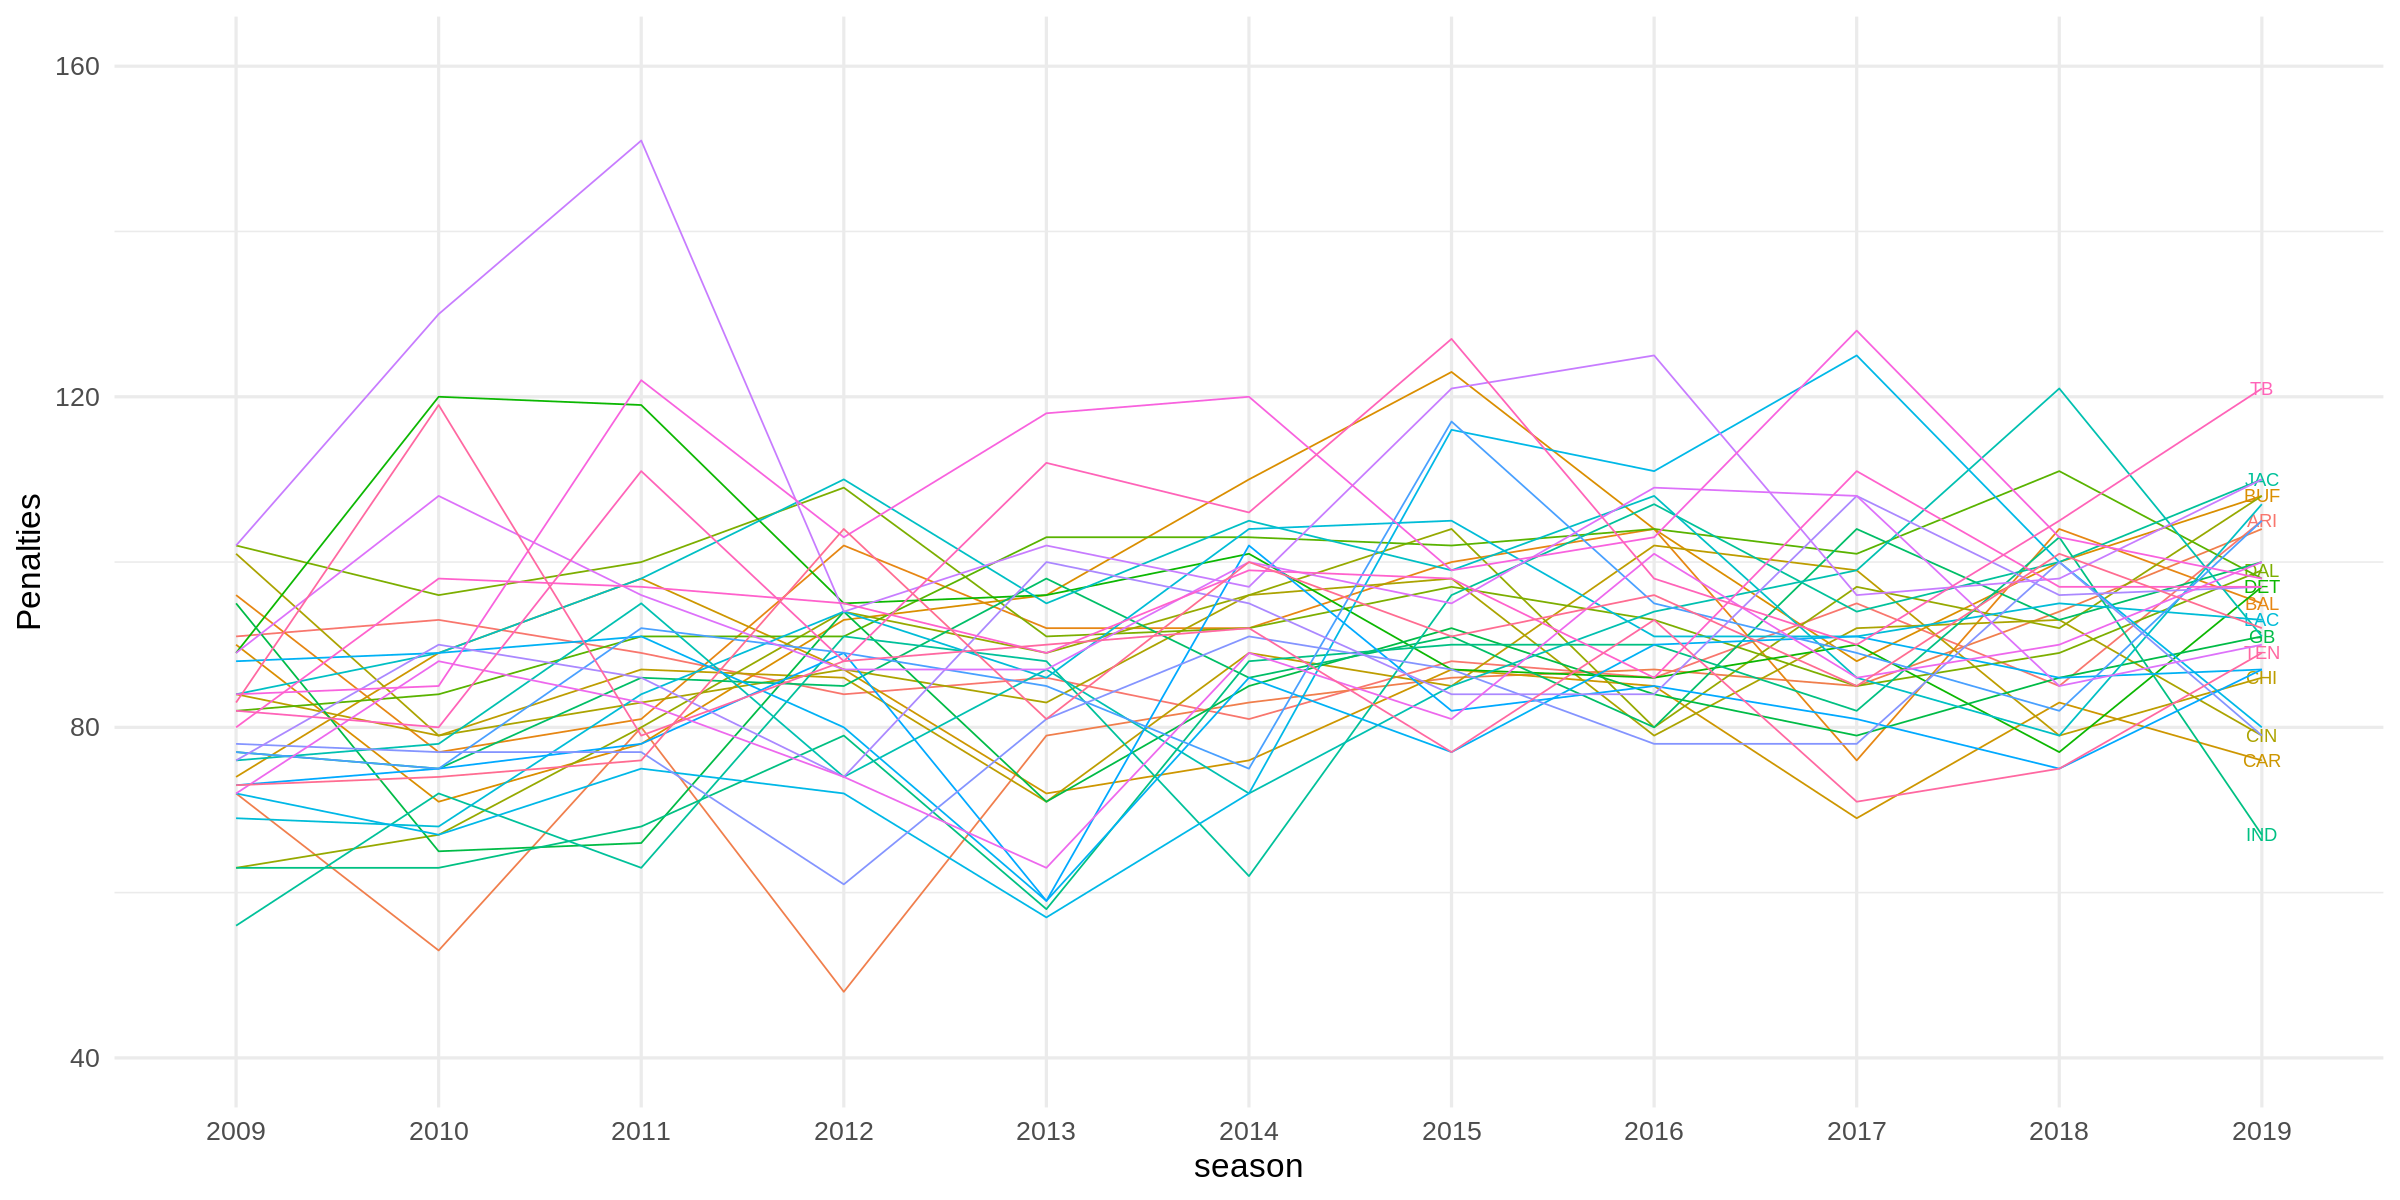

In [ ]:
options(repr.plot.width=20, repr.plot.height=10)

penalty_teams_per_season %>%
group_by(penalty_team) %>%
ggplot(aes(x= season , y=n, color=penalty_team)) +
geom_text(data=penalty_teams_per_season %>% filter(season == 2019), aes(label=penalty_team), check_overlap = TRUE) +
geom_line() + 
xlim(2009, 2019) +
ylim(40, 160) +
labs(y = "Penalties") +
scale_x_discrete(limits= c(2009:2019))+
theme_minimal(base_size = 20) +
theme(legend.position = "none")

do same but with penalty_yards not just penalty_count

In [ ]:
pbp_all_rp %>%
select(desc, penalty, play_type)

* Rausgefunden, nicht jede FLAG führt dazu dass Play_Type = NO_PLAY - bessere Form des filterns ist penalty == 1

In [4]:
pbp_all_rp %>%
group_by(season, penalty_team) %>%
filter(penalty == 1, !str_detect(desc, "(Timeout)")) %>%
select(desc, penalty_team, penalty_yards) %>%
summarize(Sum_Penalty_Yards = sum(penalty_yards)) -> penalty_teams_yards
penalty_teams_yards


Adding missing grouping variables: `season`

`summarise()` regrouping output by 'season' (override with `.groups` argument)



season,penalty_team,Sum_Penalty_Yards
<dbl>,<chr>,<dbl>
2009,ARI,765
2009,ATL,614
2009,BAL,928
2009,BUF,689
2009,CAR,578
2009,CHI,689
2009,CIN,728
2009,CLE,542
2009,DAL,788


In [ ]:
summary(penalty_teams_yards)

     season     penalty_team       Sum_Penalty_Yards
 Min.   :2009   Length:352         Min.   : 367.0   
 1st Qu.:2011   Class :character   1st Qu.: 680.0   
 Median :2014   Mode  :character   Median : 753.0   
 Mean   :2014                      Mean   : 754.7   
 3rd Qu.:2017                      3rd Qu.: 830.0   
 Max.   :2019                      Max.   :1262.0   
                                   NA's   :3        

In [5]:
install.packages("forcats")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [6]:
library(forcats)

Warning message:
“Removed 3 rows containing non-finite values (stat_boxplot).”


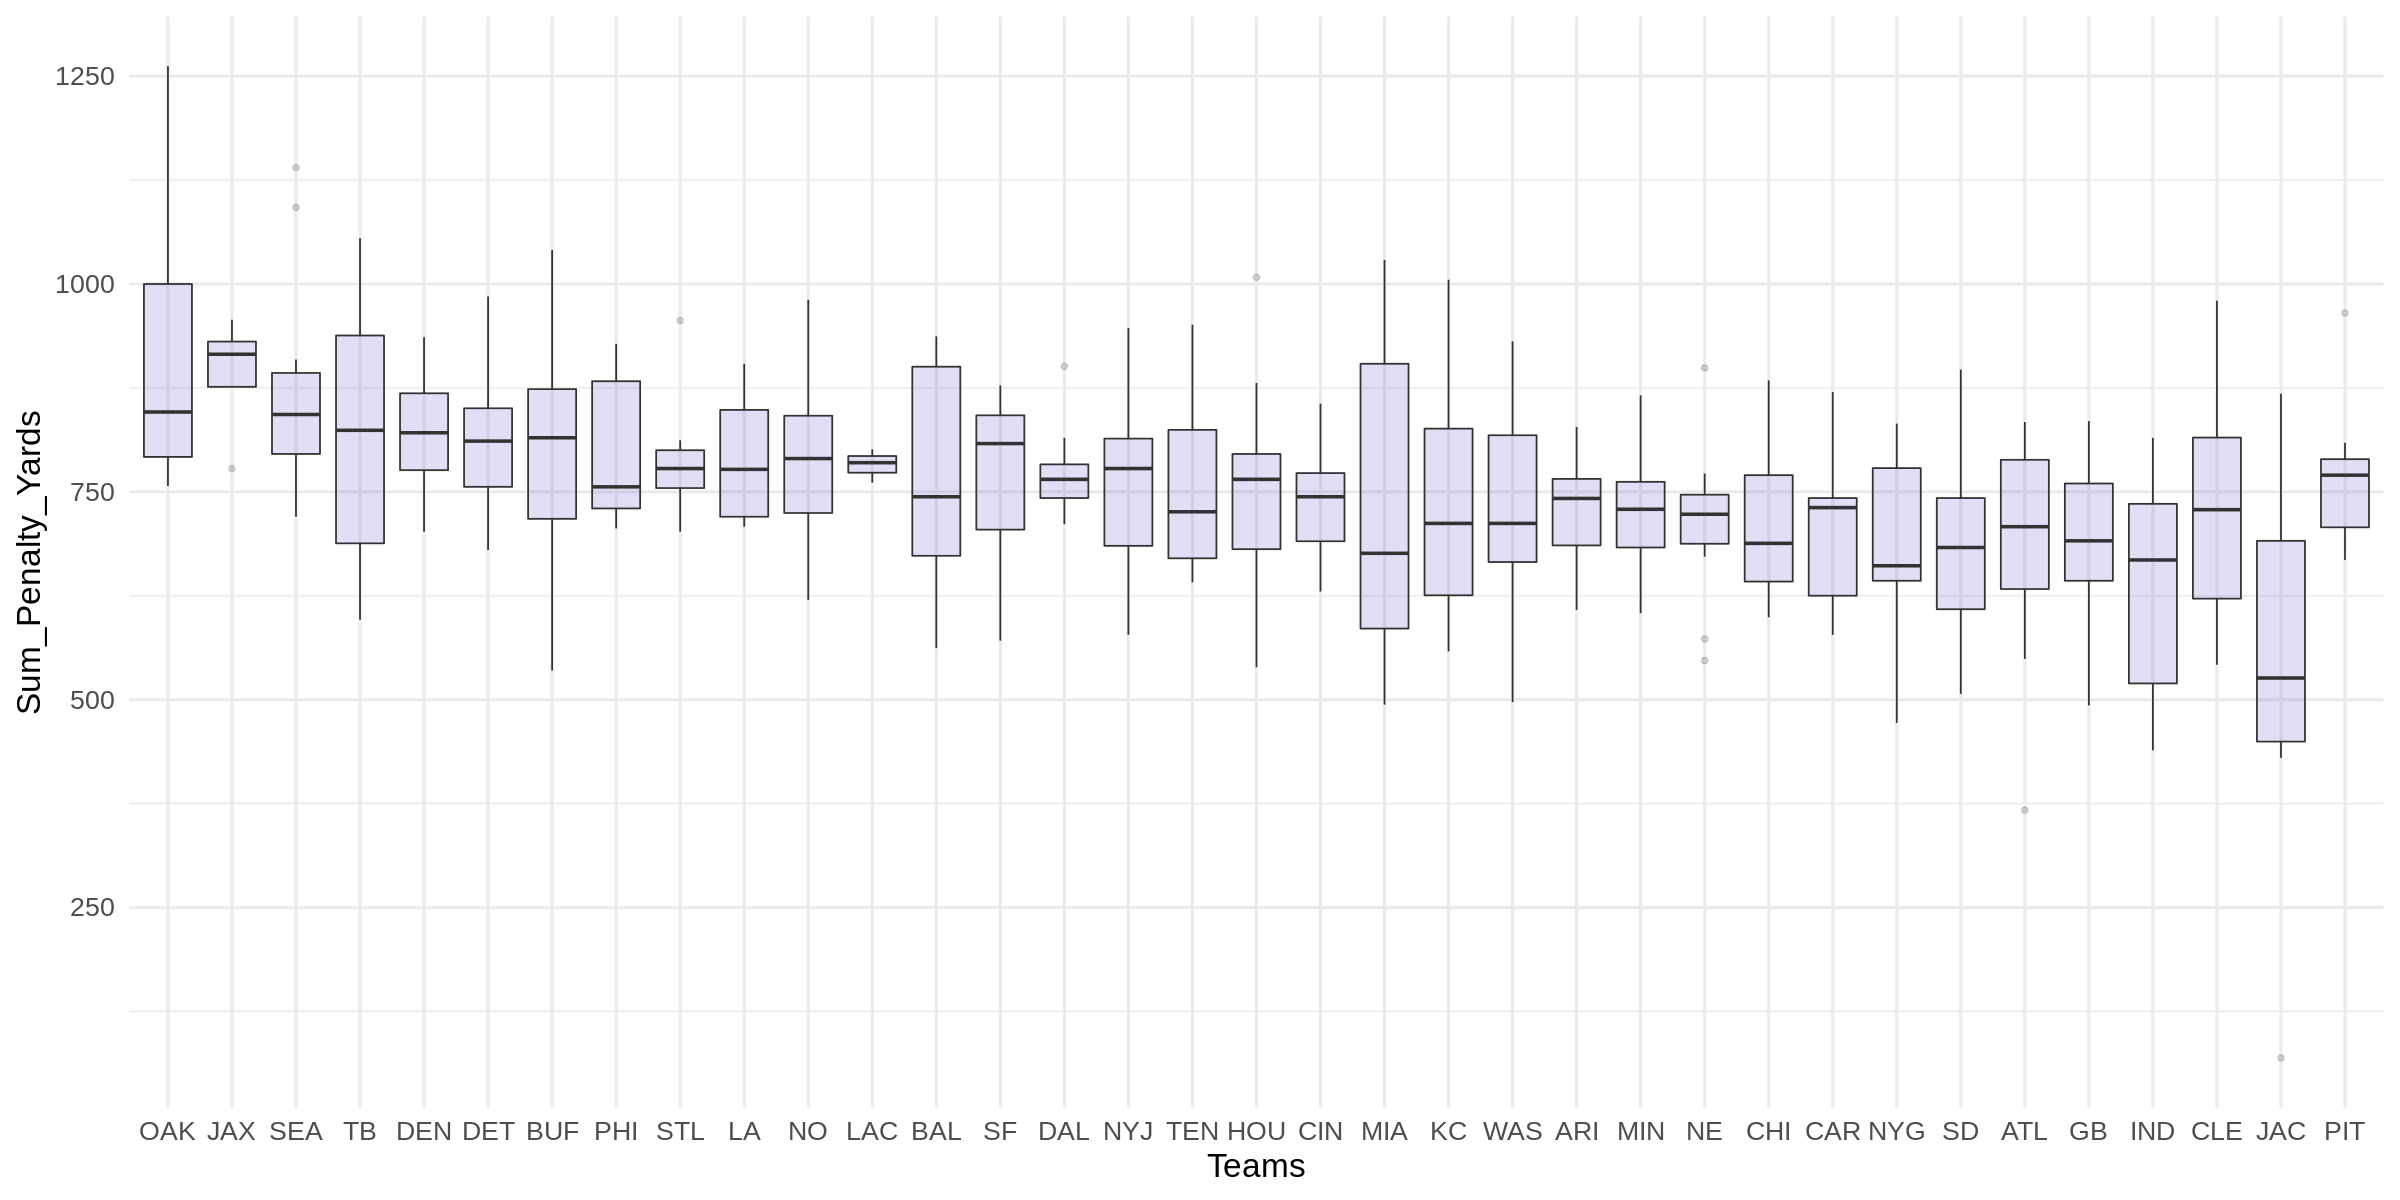

In [12]:
options(repr.plot.width=20, repr.plot.height=10)

ggplot(penalty_teams_yards, aes(x= reorder(penalty_team, -Sum_Penalty_Yards), y=Sum_Penalty_Yards)) + 
    geom_boxplot(fill="slateblue", alpha=0.2) + 
    xlab("Teams") +
    theme_minimal(base_size = 20)

- Filter for 2019 season, cumulative count of flags for the home team and the corresponding win probability
- hoping for some correlation (more flags should theoretically lead to lower wp)

In [ ]:
pbp_all_rp %>%
group_by(game_id, penalty_team) %>%
filter(season == 2019, penalty==1, home_team==penalty_team) %>%
select(home_team, home_wp, penalty_team) %>%
mutate(penalty_count = row_number()) -> correlation_team
correlation_team


Adding missing grouping variables: `game_id`



game_id,home_team,home_wp,penalty_team,penalty_count
<dbl>,<chr>,<dbl>,<chr>,<int>
2019090500,CHI,0.3796926,CHI,1
2019090500,CHI,0.3785089,CHI,2
2019090500,CHI,0.4329962,CHI,3
2019090500,CHI,0.4485202,CHI,4
2019090500,CHI,0.4483121,CHI,5
2019090500,CHI,0.4130917,CHI,6
2019090500,CHI,0.3769627,CHI,7
2019090500,CHI,0.2120613,CHI,8
2019090800,CAR,0.5556706,CAR,1


Warning message:
“Removed 3 rows containing non-finite values (stat_boxplot).”


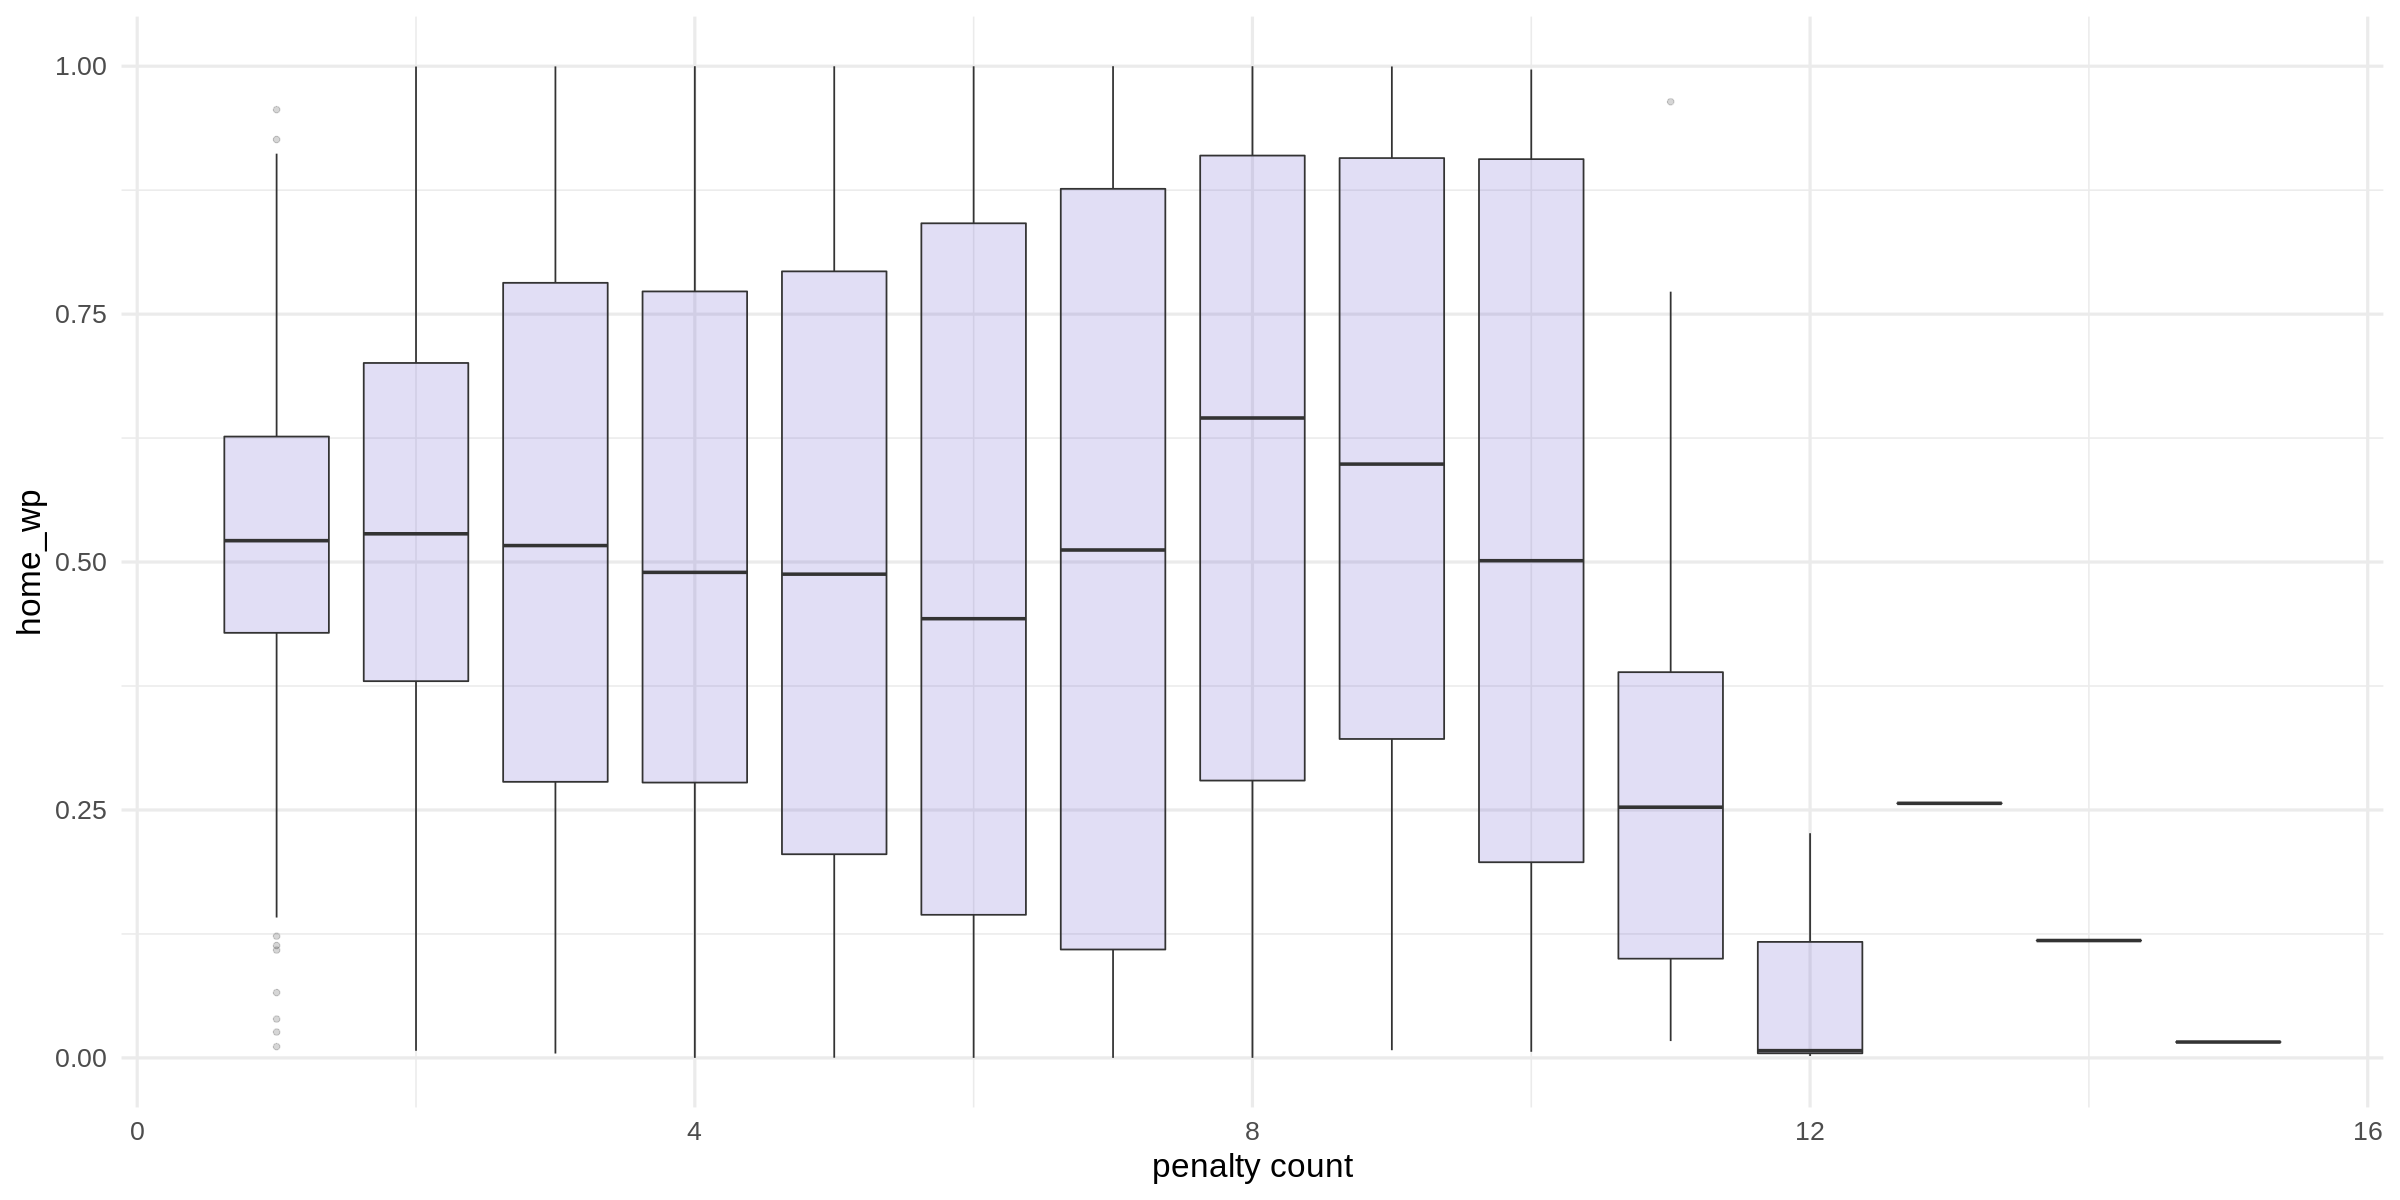

In [ ]:
options(repr.plot.width=20, repr.plot.height=10)

ggplot(correlation_team, aes(x=penalty_count, y=home_wp)) + 
    geom_boxplot(aes(group=penalty_count), fill="slateblue", alpha=0.2) + 
    xlab("penalty count") +
    theme_minimal(base_size = 20)

* Do it for all games we have

In [13]:
pbp_all_rp %>%
group_by(game_id, penalty_team) %>%
filter(penalty==1, home_team==penalty_team) %>%
select(home_team, home_wp, penalty_team) %>%
mutate(penalty_count = row_number()) -> correlation_all
correlation_all

Adding missing grouping variables: `game_id`



game_id,home_team,home_wp,penalty_team,penalty_count
<dbl>,<chr>,<dbl>,<chr>,<int>
2009091000,PIT,0.521072515,PIT,1
2009091000,PIT,0.534517749,PIT,2
2009091000,PIT,0.498324130,PIT,3
2009091000,PIT,0.445656504,PIT,4
2009091000,PIT,0.539794912,PIT,5
2009091000,PIT,0.459829246,PIT,6
2009091304,CLE,0.587935329,CLE,1
2009091304,CLE,0.424560550,CLE,2
2009091304,CLE,0.435725178,CLE,3


* see if we need to remove outliers


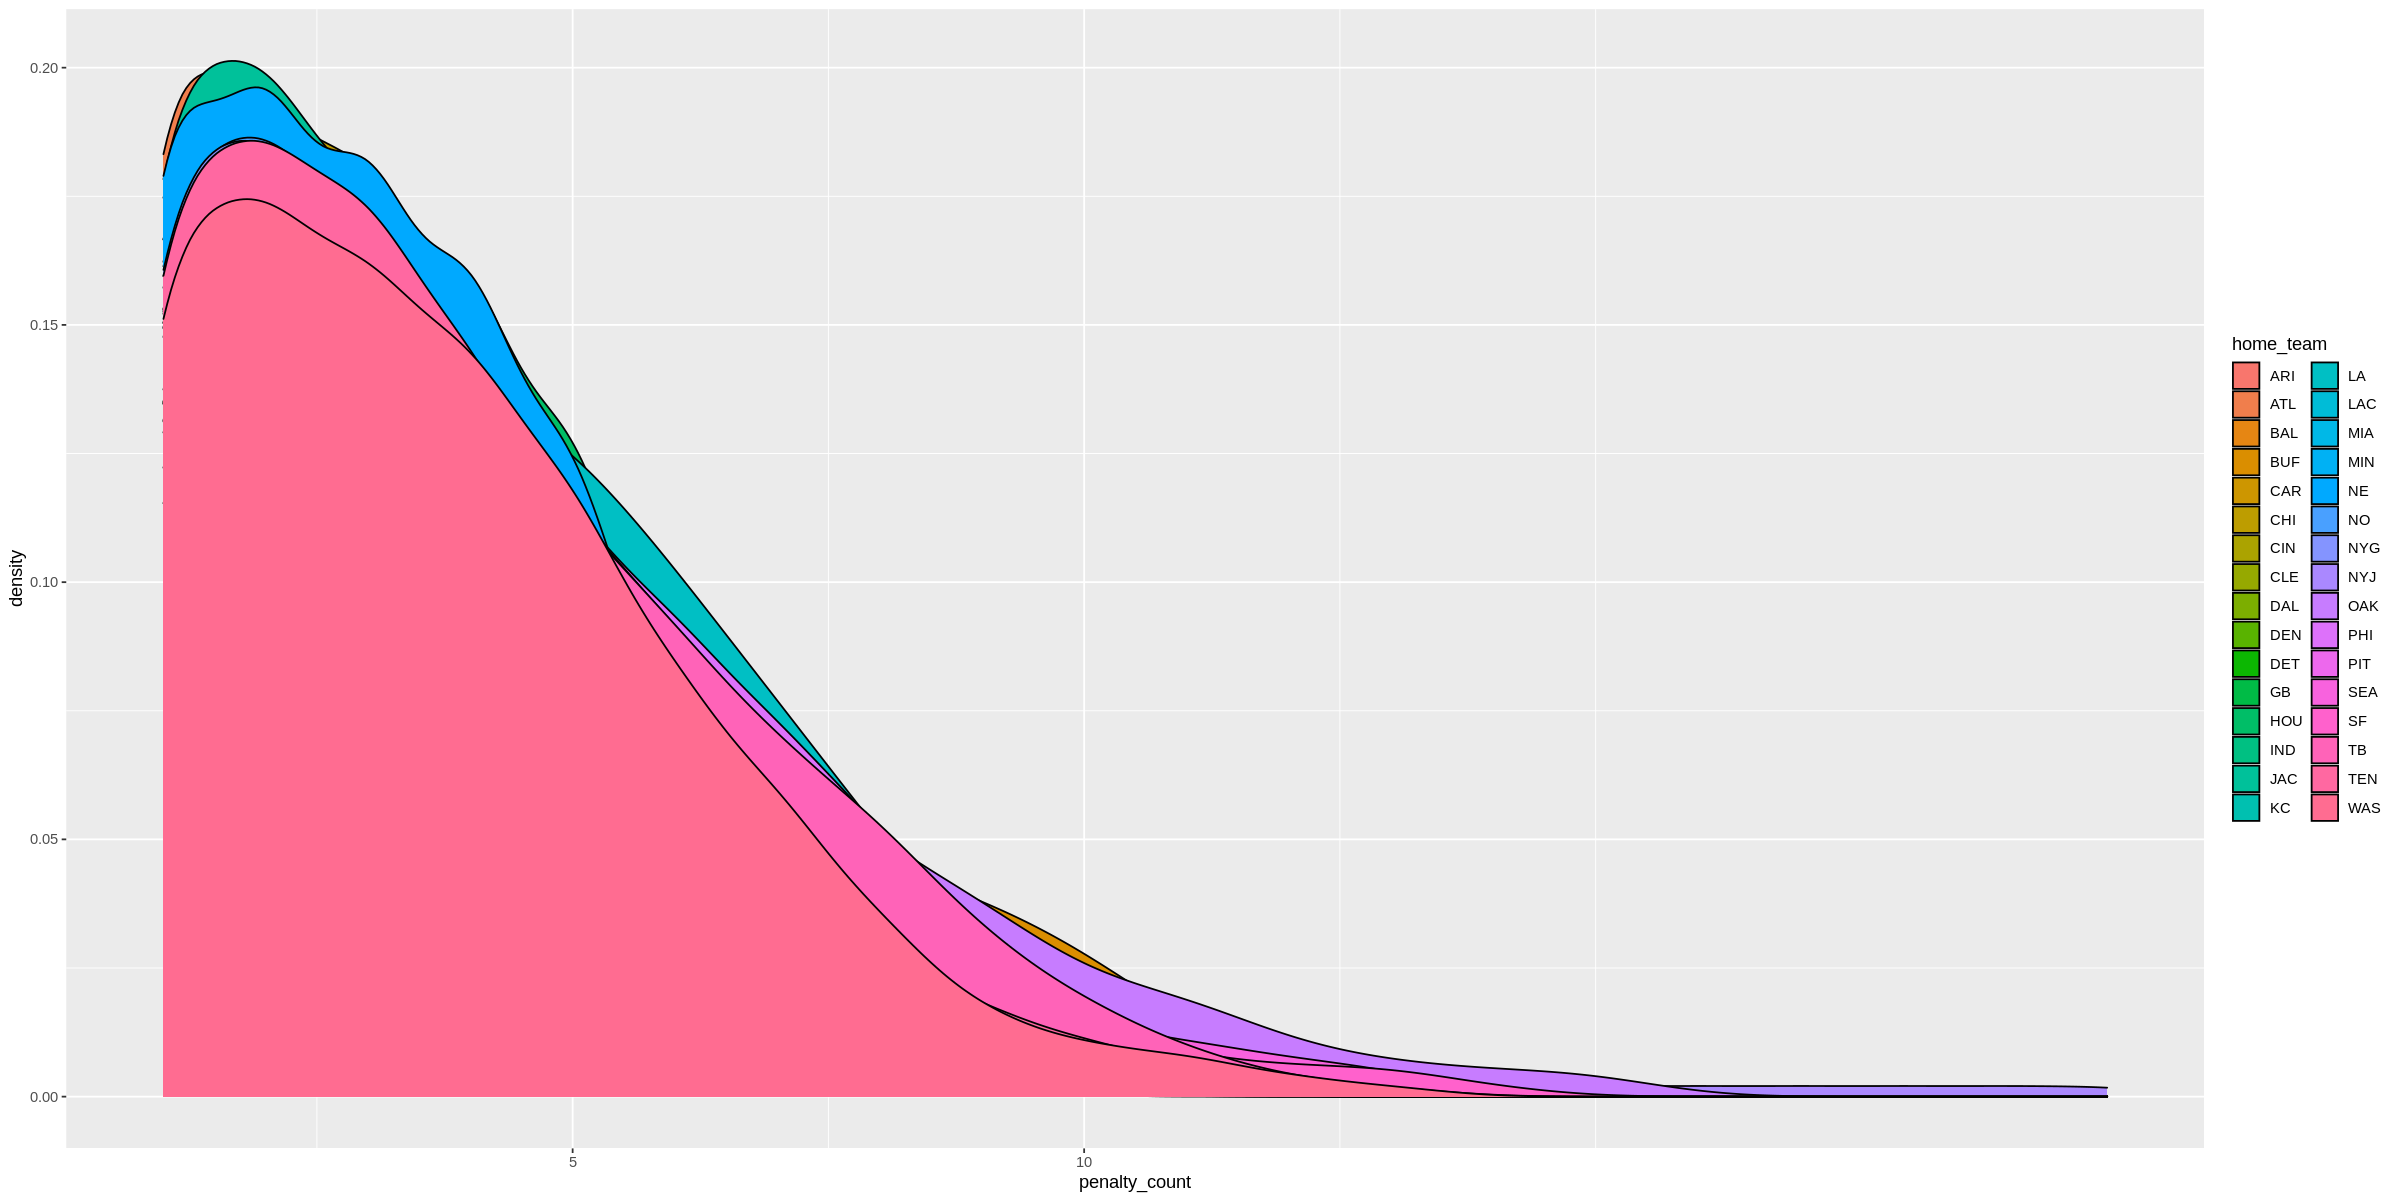

In [18]:
correlation_all %>%
ggplot(aes(x= penalty_count, fill = home_team)) +
geom_density()+
scale_x_continuous(breaks = c(-3, 5, 10))

In [ ]:
correlation_all %>%
group_by(penalty_count) %>%
count(penalty_count)

penalty_count,n
<int>,<int>
1,2797
2,2722
3,2523
4,2188
5,1749
6,1284
7,876
8,563
9,342


* guess we can filter out < 15

Warning message:
“Removed 54 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 54 rows containing non-finite values (stat_summary).”


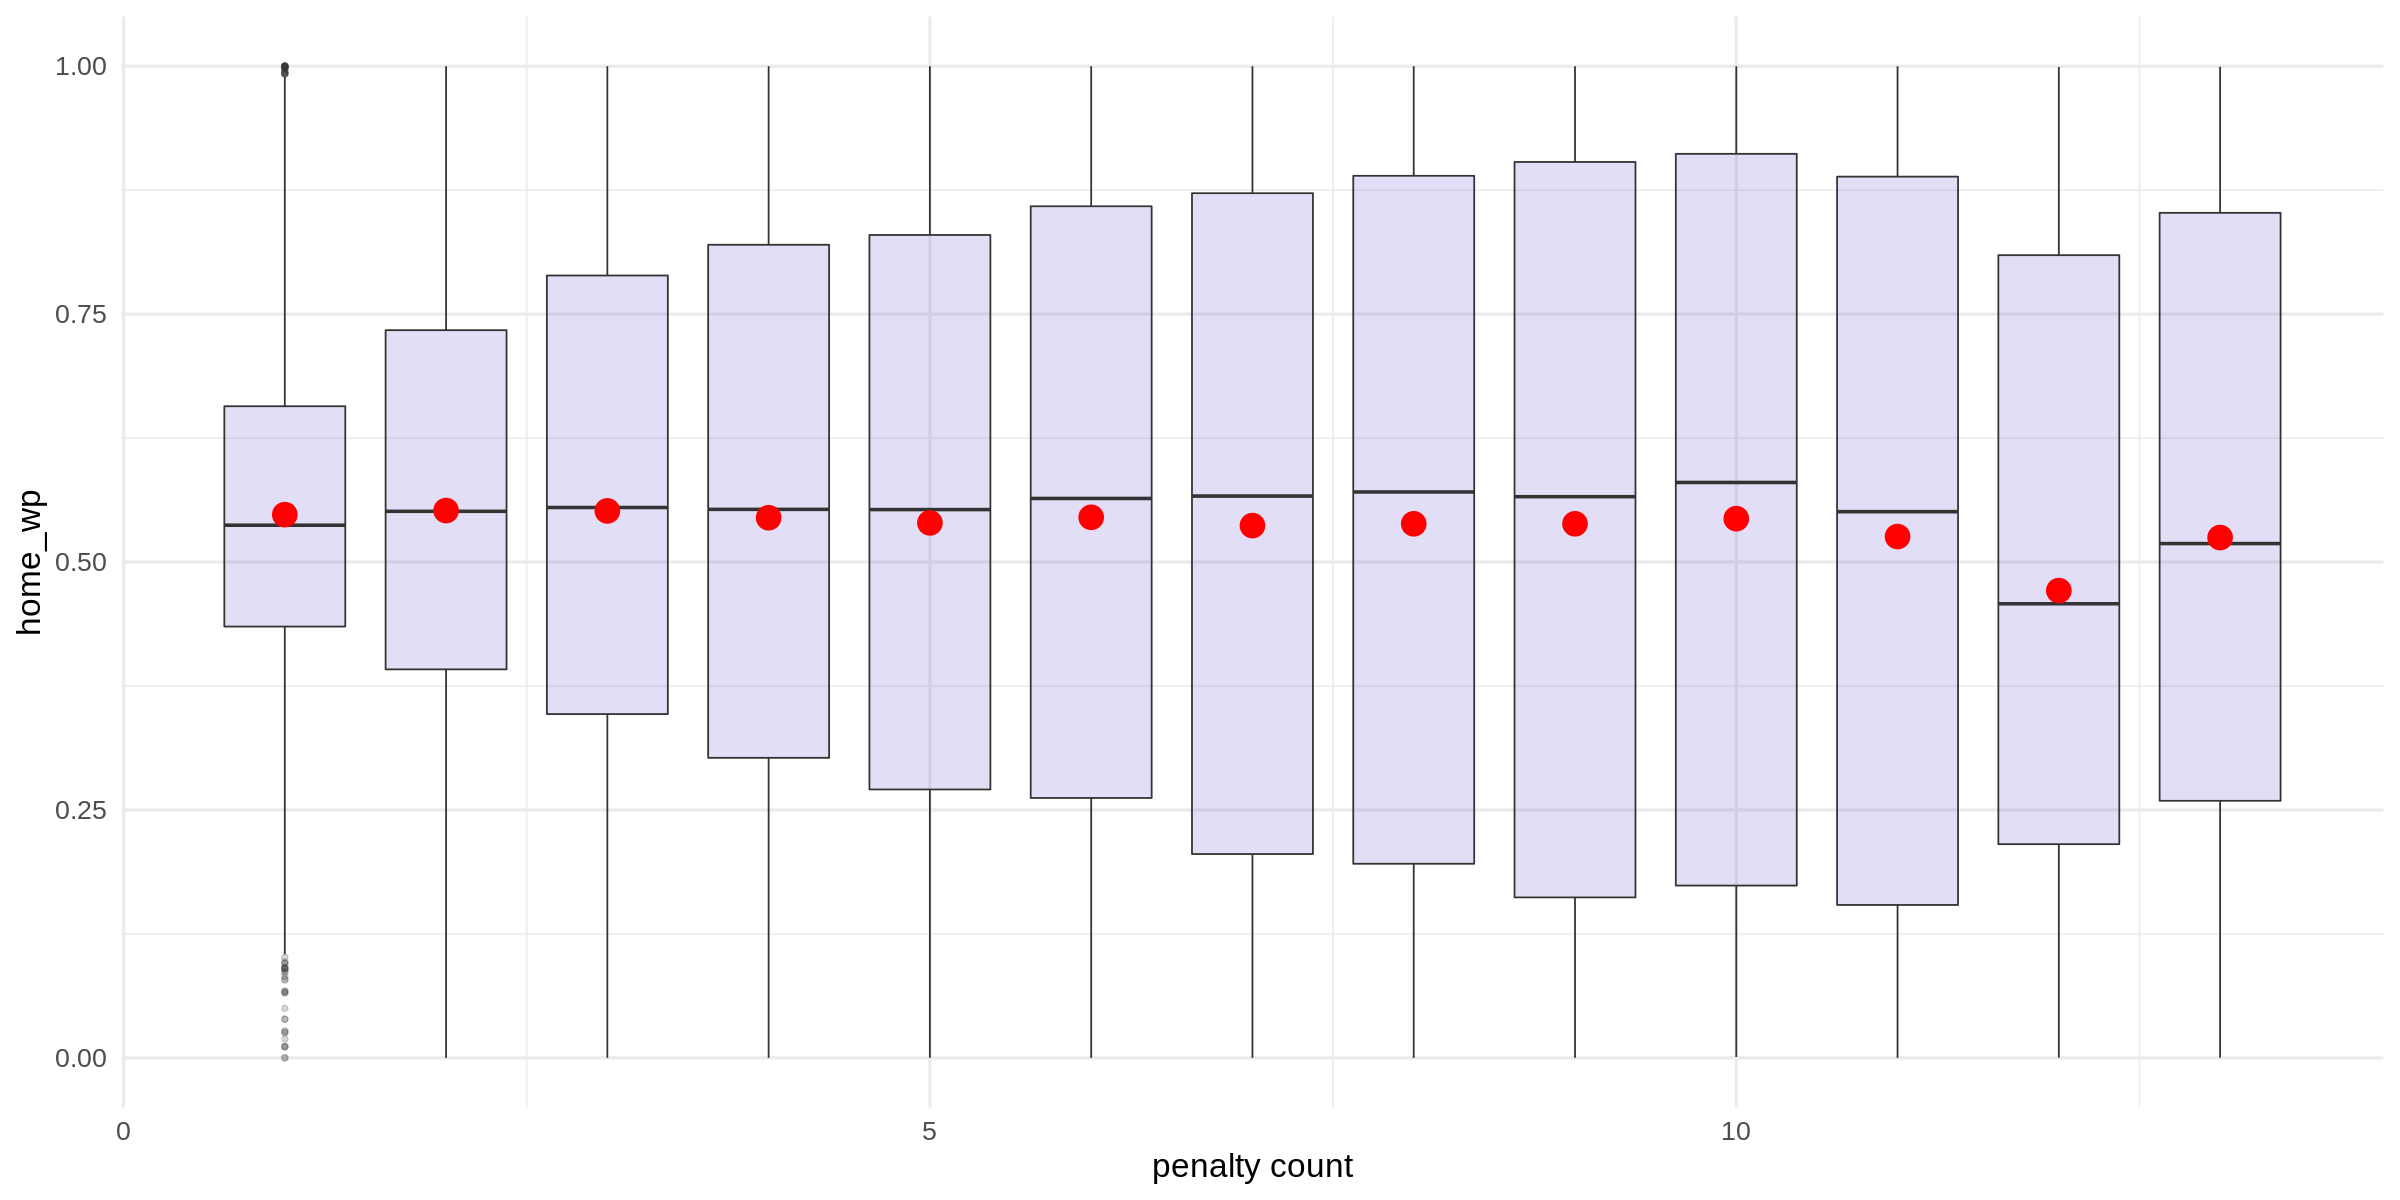

In [ ]:
options(repr.plot.width=20, repr.plot.height=10)

correlation_all %>%
  filter(penalty_count < 14) %>%
  ggplot(aes(x=penalty_count, y=home_wp)) + 
    geom_boxplot(aes(group=penalty_count), fill="slateblue", alpha=0.2) + 
    stat_summary(fun=mean, geom= "point", shape = 20, size=10, color="red", fill="red") +
    xlab("penalty count") +
    theme_minimal(base_size = 20)

Warning message:
“Removed 54 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 54 rows containing non-finite values (stat_summary).”


NULL

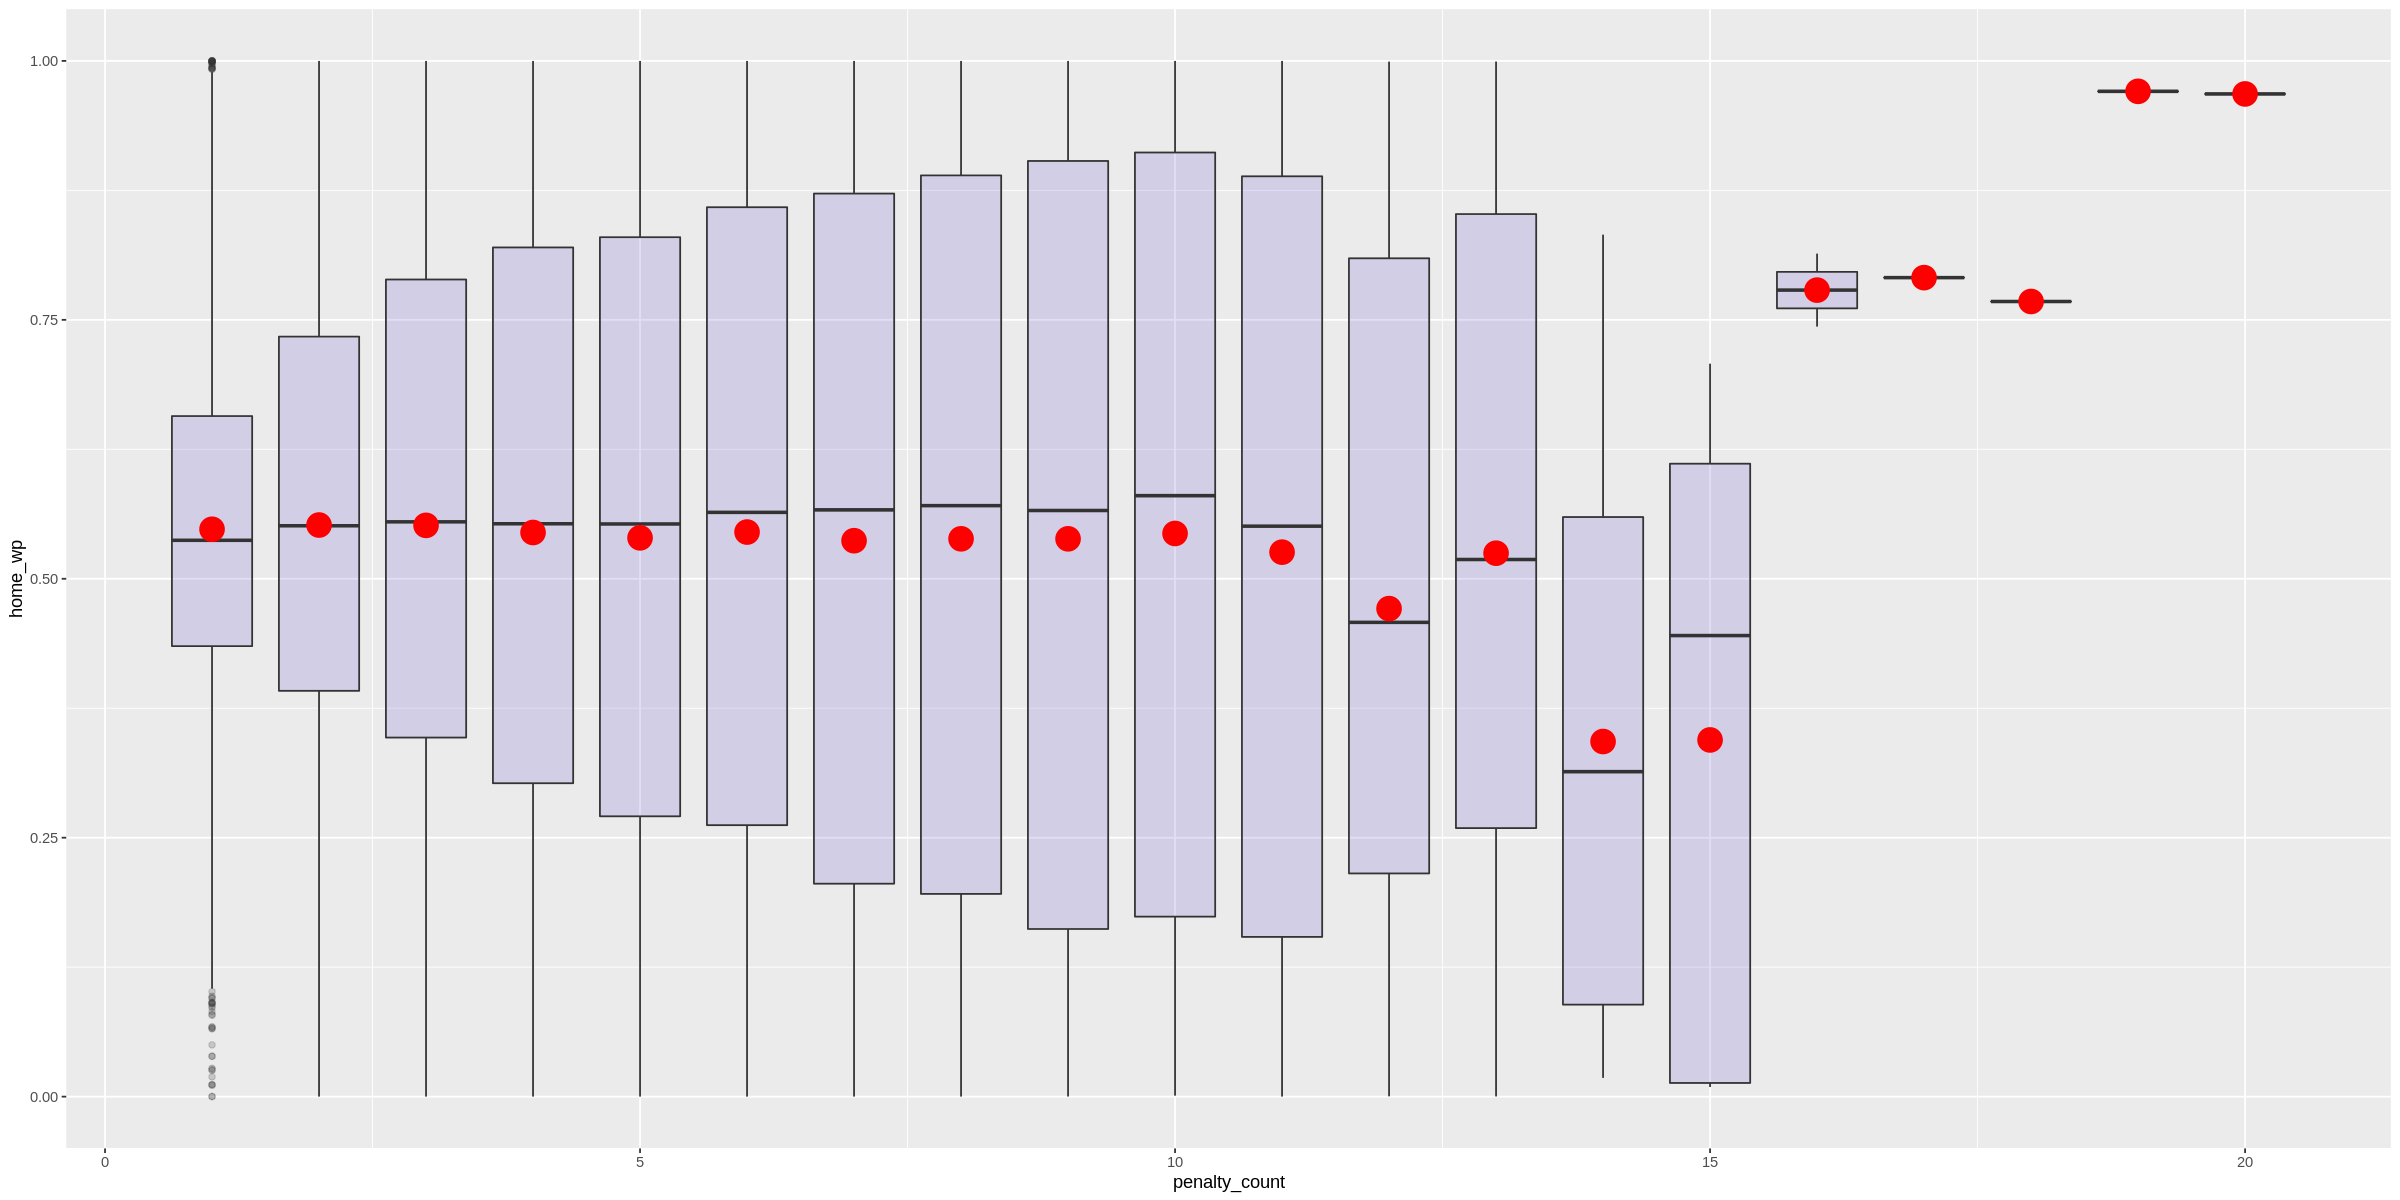

In [ ]:
options(repr.plot.width=20, repr.plot.height=10)

ggplot(correlation_all, aes(x=penalty_count, y=home_wp)) + 
    geom_boxplot(aes(group=penalty_count), fill="slateblue", alpha=0.2) + 
    stat_summary(fun=mean, geom= "point", shape = 20, size=10, color="red", fill="red") +
    xlab("penalty count") +
    theme_minimal(base_size = 20)

In [ ]:
correlation_all %>%
group_by(penalty_count) %>%
count(penalty_count)

penalty_count,n
<int>,<int>
1,2797
2,2722
3,2523
4,2188
5,1749
6,1284
7,876
8,563
9,342


- DO the same for Away Teams


In [ ]:
pbp_all_rp %>%
group_by(game_id, penalty_team) %>%
filter(penalty==1, away_team==penalty_team) %>%
select(away_team, away_wp, penalty_team) %>%
mutate(penalty_count = row_number()) -> correlation_team_away
correlation_team_away

Adding missing grouping variables: `game_id`



game_id,away_team,away_wp,penalty_team,penalty_count
<dbl>,<chr>,<dbl>,<chr>,<int>
2009091000,TEN,0.55100161,TEN,1
2009091000,TEN,0.49037651,TEN,2
2009091000,TEN,0.51678854,TEN,3
2009091000,TEN,0.59859761,TEN,4
2009091304,MIN,0.59895474,MIN,1
2009091304,MIN,0.55012922,MIN,2
2009091304,MIN,0.87889909,MIN,3
2009091307,DET,0.32784062,DET,1
2009091307,DET,0.18204945,DET,2


Warning message:
“Removed 67 rows containing non-finite values (stat_boxplot).”


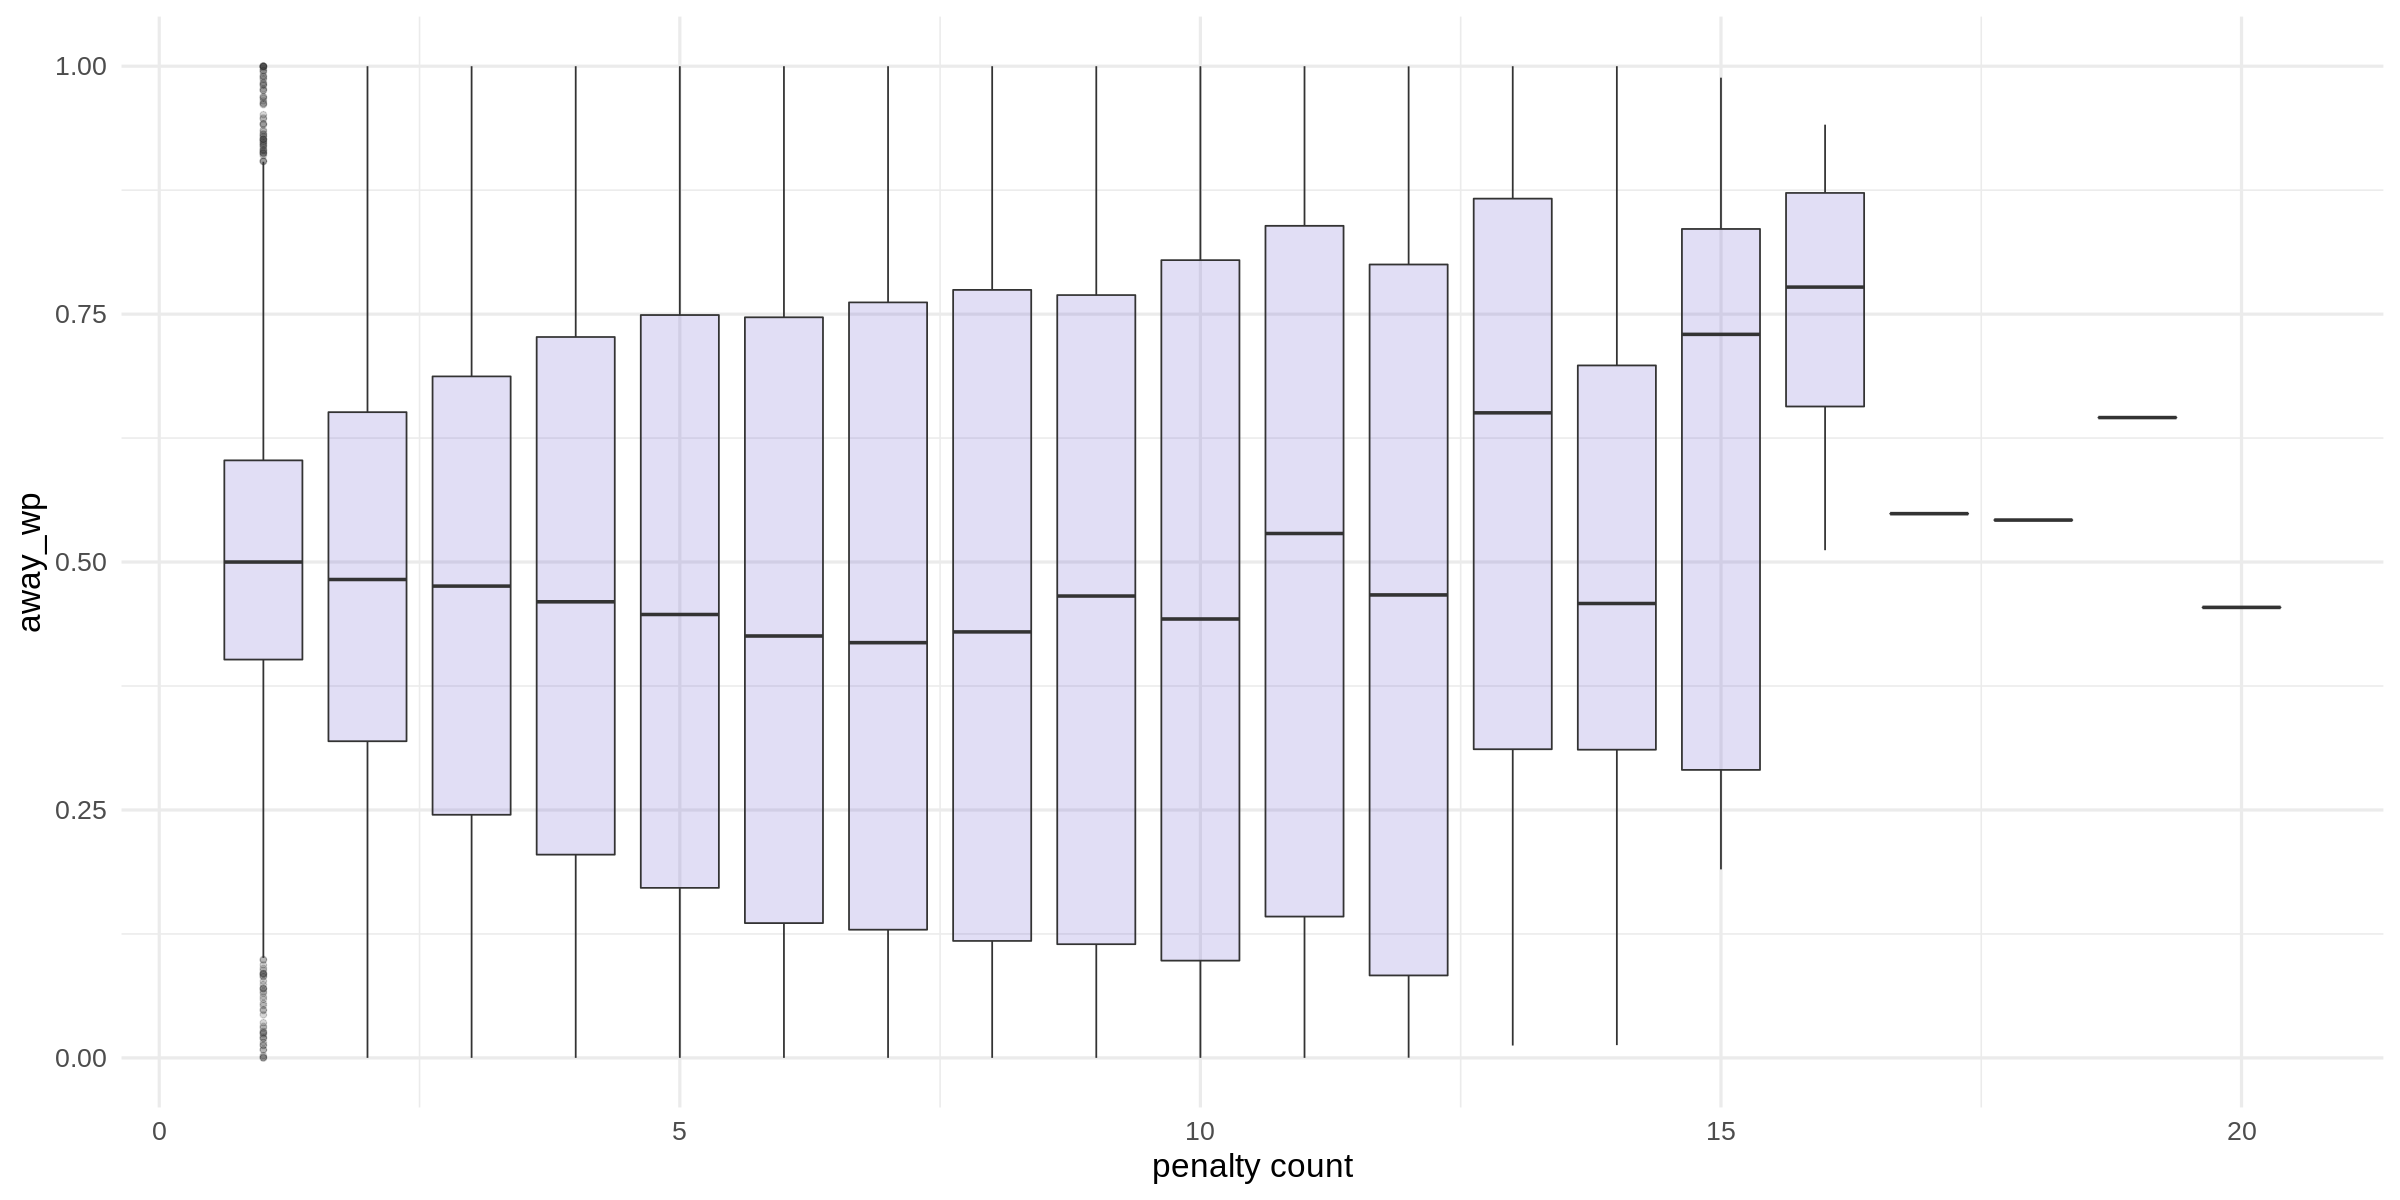

In [ ]:
options(repr.plot.width=20, repr.plot.height=10)

ggplot(correlation_team_away, aes(x=penalty_count, y=away_wp)) + 
    geom_boxplot(aes(group=penalty_count), fill="slateblue", alpha=0.2) + 
    xlab("penalty count") +
    theme_minimal(base_size = 20)

Do the flag correlation to win probability but with penalty yards

In [ ]:
pbp_all_rp %>%
group_by(game_id, penalty_team) %>%
filter(penalty==1, home_team==penalty_team) %>%
select(home_team, home_wp, penalty_team, penalty_yards) %>%
mutate(SUM_YARDS = cumsum(penalty_yards)) -> penalty_yards_correlation
penalty_yards_correlation



Adding missing grouping variables: `game_id`



game_id,home_team,home_wp,penalty_team,penalty_yards,SUM_YARDS
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
2009091000,PIT,0.521072515,PIT,15,15
2009091000,PIT,0.534517749,PIT,10,25
2009091000,PIT,0.498324130,PIT,10,35
2009091000,PIT,0.445656504,PIT,15,50
2009091000,PIT,0.539794912,PIT,5,55
2009091000,PIT,0.459829246,PIT,5,60
2009091304,CLE,0.587935329,CLE,10,10
2009091304,CLE,0.424560550,CLE,5,15
2009091304,CLE,0.435725178,CLE,16,31


In [ ]:
penalty_yards_correlation %>%
group_by(SUM_YARDS) %>%
summarize(Mean_WP = mean(home_wp, na.rm=TRUE)) -> co_plot
co_plot

`summarise()` ungrouping output (override with `.groups` argument)



SUM_YARDS,Mean_WP
<dbl>,<dbl>
0,0.4905532
1,0.4628771
2,0.3858134
3,0.4450950
4,0.4953053
5,0.5489755
6,0.5539428
7,0.5012092
8,0.4583087


Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


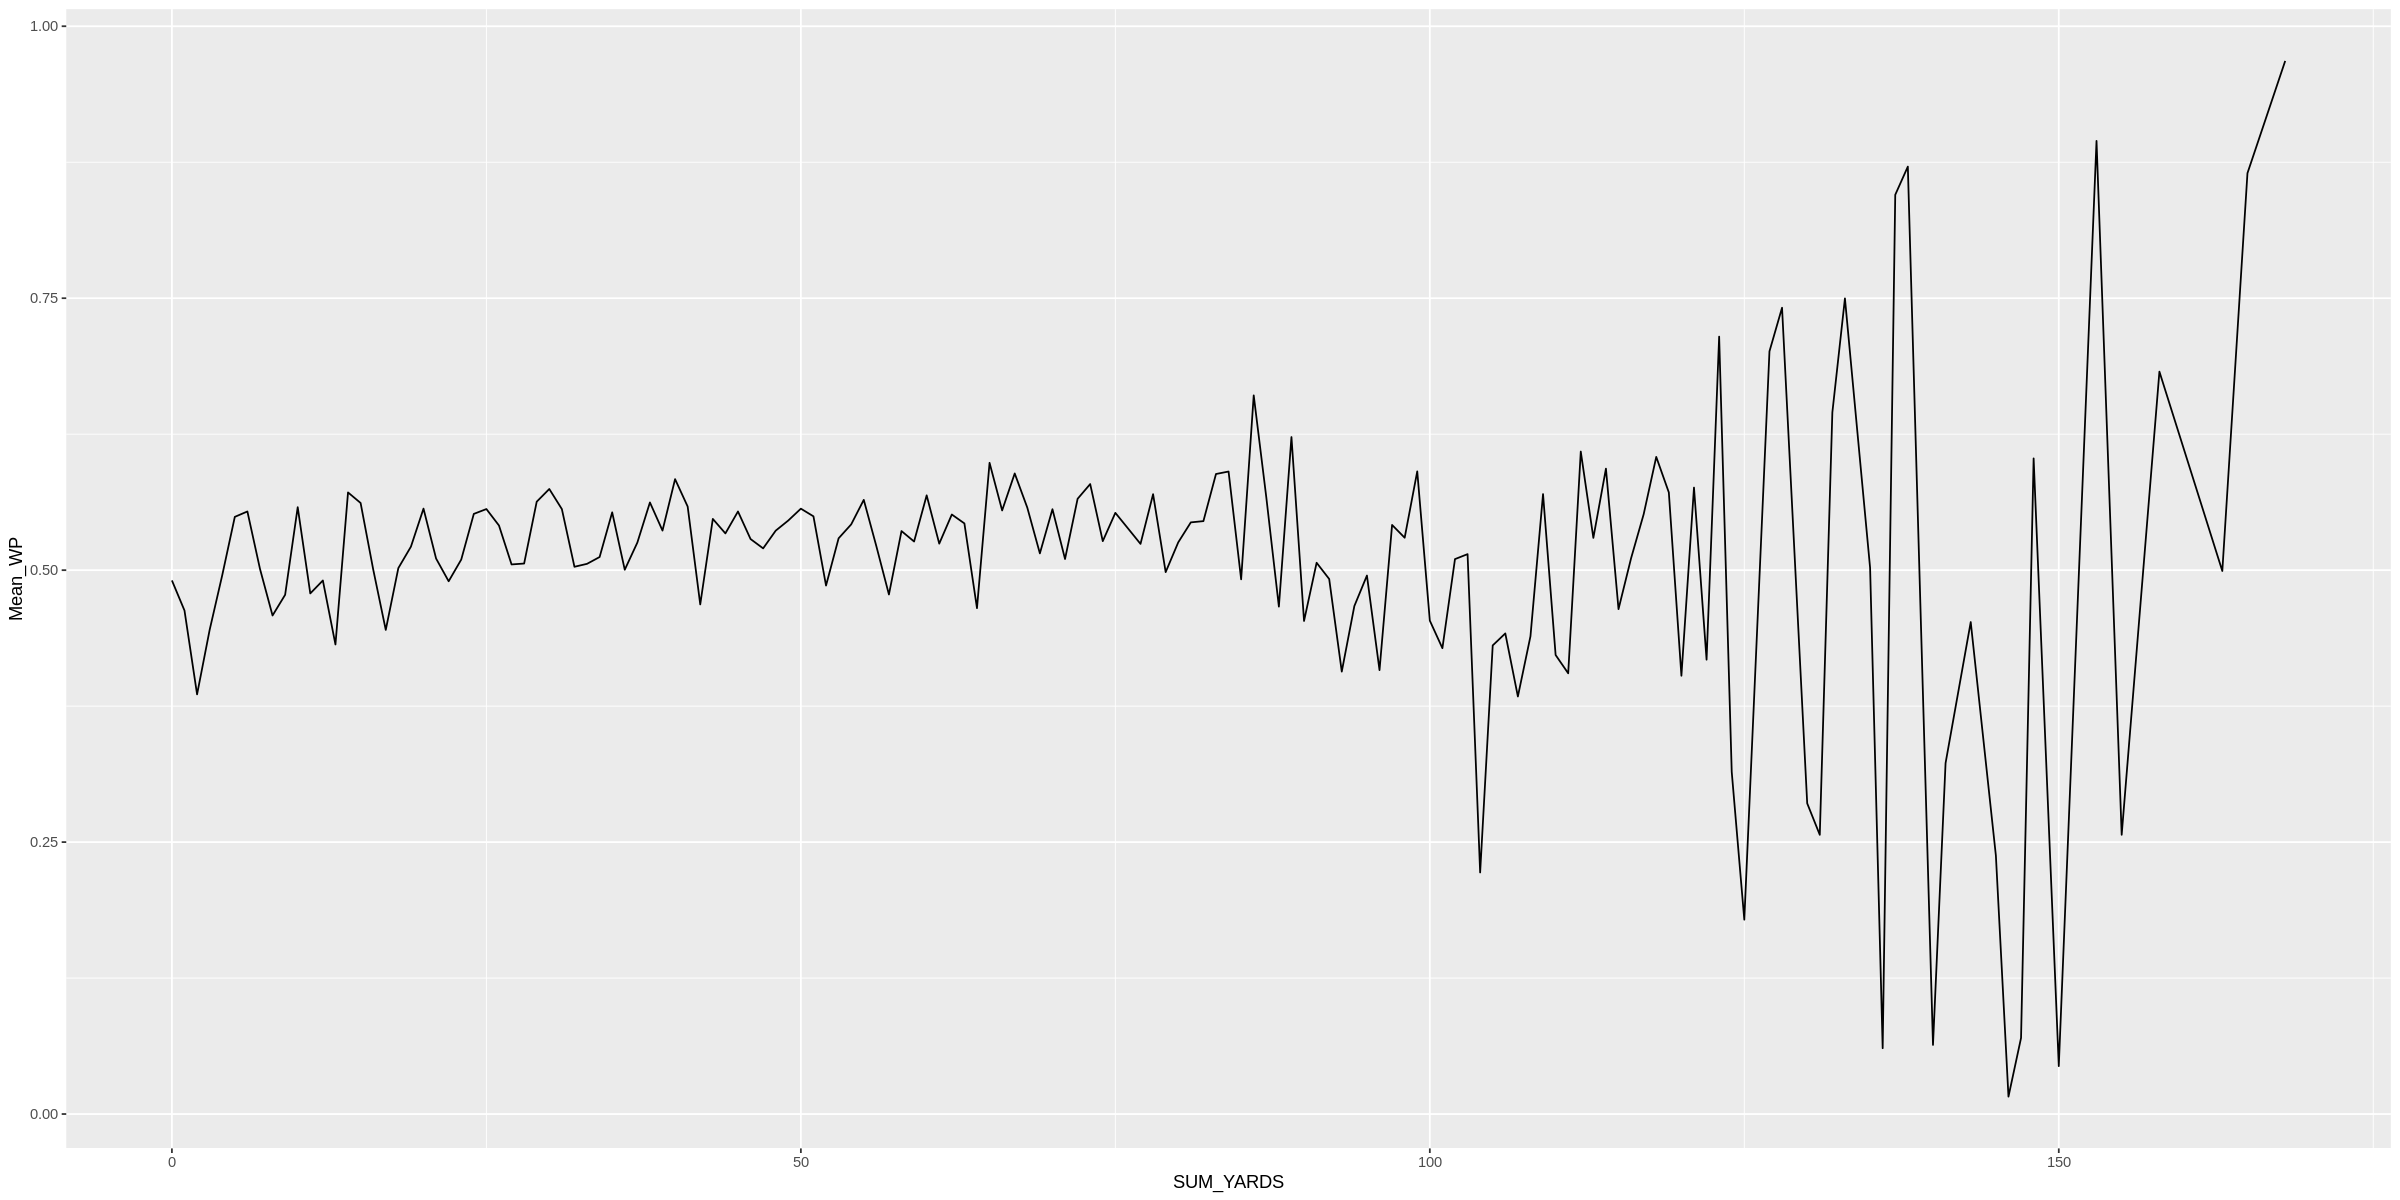

In [ ]:
ggplot(co_plot, aes(x= SUM_YARDS, y=Mean_WP)) +
geom_line()

In [ ]:
pbp_all_rp %>%
names()

[1] "play_id"                             
  [2] "game_id"                             
  [3] "home_team"                           
  [4] "away_team"                           
  [5] "posteam"                             
  [6] "posteam_type"                        
  [7] "defteam"                             
  [8] "side_of_field"                       
  [9] "yardline_100"                        
 [10] "game_date"                           
 [11] "quarter_seconds_remaining"           
 [12] "half_seconds_remaining"              
 [13] "game_seconds_remaining"              
 [14] "game_half"                           
 [15] "quarter_end"                         
 [16] "drive"                               
 [17] "sp"                                  
 [18] "qtr"                                 
 [19] "down"                                
 [20] "goal_to_go"                          
 [21] "time"                                
 [22] "yrdln"                               
 [23] "ydstogo"                             
 [24] "ydsnet"                              
 [25] "desc"                                
 [26] "play_type"                           
 [27] "yards_gained"                        
 [28] "shotgun"                             
 [29] "no_huddle"                           
 [30] "qb_dropback"                         
 [31] "qb_kneel"                            
 [32] "qb_spike"                            
 [33] "qb_scramble"                         
 [34] "pass_length"                         
 [35] "pass_location"                       
 [36] "air_yards"                           
 [37] "yards_after_catch"                   
 [38] "run_location"                        
 [39] "run_gap"                             
 [40] "field_goal_result"                   
 [41] "kick_distance"                       
 [42] "extra_point_result"                  
 [43] "two_point_conv_result"               
 [44] "home_timeouts_remaining"             
 [45] "away_timeouts_remaining"             
 [46] "timeout"                             
 [47] "timeout_team"                        
 [48] "td_team"                             
 [49] "posteam_timeouts_remaining"          
 [50] "defteam_timeouts_remaining"          
 [51] "total_home_score"                    
 [52] "total_away_score"                    
 [53] "posteam_score"                       
 [54] "defteam_score"                       
 [55] "score_differential"                  
 [56] "posteam_score_post"                  
 [57] "defteam_score_post"                  
 [58] "score_differential_post"             
 [59] "no_score_prob"                       
 [60] "opp_fg_prob"                         
 [61] "opp_safety_prob"                     
 [62] "opp_td_prob"                         
 [63] "fg_prob"                             
 [64] "safety_prob"                         
 [65] "td_prob"                             
 [66] "extra_point_prob"                    
 [67] "two_point_conversion_prob"           
 [68] "ep"                                  
 [69] "epa"                                 
 [70] "total_home_epa"                      
 [71] "total_away_epa"                      
 [72] "total_home_rush_epa"                 
 [73] "total_away_rush_epa"                 
 [74] "total_home_pass_epa"                 
 [75] "total_away_pass_epa"                 
 [76] "air_epa"                             
 [77] "yac_epa"                             
 [78] "comp_air_epa"                        
 [79] "comp_yac_epa"                        
 [80] "total_home_comp_air_epa"             
 [81] "total_away_comp_air_epa"             
 [82] "total_home_comp_yac_epa"             
 [83] "total_away_comp_yac_epa"             
 [84] "total_home_raw_air_epa"              
 [85] "total_away_raw_air_epa"              
 [86] "total_home_raw_yac_epa"              
 [87] "total_away_raw_yac_epa"              
 [88] "wp"                                  
 [89] "def_wp"                            

In [7]:
pbp_all_rp %>%
filter(season==2019, play_type == "run", rusher_player_name == "L.Jackson") %>%
select(desc, posteam, yards_gained, qb_scramble, rusher_player_name, play_type)

desc,posteam,yards_gained,qb_scramble,rusher_player_name,play_type
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
(5:11) (Shotgun) L.Jackson right end to BAL 17 for 3 yards (J.Ledbetter; E.Rowe).,BAL,3,0,L.Jackson,run
"(14:54) (Shotgun) L.Jackson up the middle to MIA 40 for 4 yards (C.Harris). PENALTY on MIA-A.Moss, Defensive Holding, 5 yards, enforced at MIA 40.",BAL,4,0,L.Jackson,run
(10:01) (Shotgun) L.Jackson left end pushed ob at ARI 42 for 19 yards (D.Swearinger).,BAL,19,0,L.Jackson,run
"(5:17) (Shotgun) L.Jackson left guard to ARI 43 for -1 yards (C.Peters, J.Hicks).",BAL,-1,0,L.Jackson,run
(:51) (Shotgun) L.Jackson left end pushed ob at ARI 22 for 16 yards (D.Swearinger).,BAL,16,0,L.Jackson,run
"(8:26) (No Huddle, Shotgun) L.Jackson scrambles right end pushed ob at BAL 21 for 6 yards (J.Hicks).",BAL,6,1,L.Jackson,run
(7:45) (Shotgun) L.Jackson scrambles up the middle to BAL 26 for 5 yards (T.Suggs).,BAL,5,1,L.Jackson,run
(7:04) (Shotgun) L.Jackson left end to BAL 44 for 18 yards (J.Hicks).,BAL,18,0,L.Jackson,run
(5:09) (Shotgun) J.Hurst reported in as eligible. L.Jackson right guard to ARI 11 for 1 yard (B.Baker).,BAL,1,0,L.Jackson,run


* QB Stats

In [6]:
options(digits=3)


pbp_all_rp %>%
filter(season==2019, play_type== "pass", yards_gained >= 0) %>%
group_by(passer_player_name, posteam) %>%
summarise(Games_Played = n_distinct(game_date),
            Total_Passes = sum(pass_attempt),
            Completed_Passes = sum(complete_pass),
            Incomplete_Passes = sum(incomplete_pass),
            Completion_Rate = round(Completed_Passes/Total_Passes, 3)*100,
            Total_Yards = sum(yards_gained),
            Yards_per_Attempt = sum(yards_gained/Total_Passes),
            Yards_per_Completion = sum(yards_gained/Completed_Passes),
            Average_EPA = round(mean(epa), 3),
            Interceptions = sum(interception),
            Interception_Rate = round(Interceptions/Total_Passes, 3)*100,
            TDs = sum(touchdown),
            TD_Rate = round(TDs/Total_Passes, 3)*100,
            TDs_per_Interception= round(TDs/Interceptions, 3)) %>%
      arrange(-Total_Yards) %>%
      filter(Total_Yards > 500) -> QB_Data

QB_Data

`summarise()` regrouping output by 'passer_player_name' (override with `.groups` argument)



passer_player_name,posteam,Games_Played,Total_Passes,Completed_Passes,Incomplete_Passes,Completion_Rate,Total_Yards,Yards_per_Attempt,Yards_per_Completion,Average_EPA,Interceptions,Interception_Rate,TDs,TD_Rate,TDs_per_Interception
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
J.Winston,TB,16,616,375,208,60.9,5125,8.32,13.67,0.229,28,4.5,40,6.5,1.429
D.Prescott,DAL,16,585,380,194,65.0,4910,8.39,12.92,0.306,9,1.5,30,5.1,3.333
J.Goff,LA,16,614,383,213,62.4,4679,7.62,12.22,0.212,15,2.4,25,4.1,1.667
P.Rivers,LAC,16,574,378,173,65.9,4660,8.12,12.33,0.263,20,3.5,24,4.2,1.200
M.Ryan,ATL,15,607,396,193,65.2,4493,7.40,11.35,0.269,12,2.0,28,4.6,2.333
R.Wilson,SEA,16,513,334,166,65.1,4127,8.04,12.36,0.291,5,1.0,34,6.6,6.800
T.Brady,NE,16,592,356,228,60.1,4105,6.93,11.53,0.174,6,1.0,26,4.4,4.333
C.Wentz,PHI,16,591,371,210,62.8,4090,6.92,11.02,0.204,5,0.8,27,4.6,5.400
D.Carr,OAK,16,499,350,138,70.1,4079,8.17,11.65,0.288,8,1.6,24,4.8,3.000


In [7]:
pbp_all_rp %>%
filter(season == 2019, rusher_player_name %in% QB_Data$passer_player_name, play_type == "run") %>%
group_by(rusher_player_name, posteam) %>%
summarise(Games_Played = n_distinct(game_date),
            Total_Runs= n(),
            Running_Yards = sum(yards_gained),
            Running_TDs= sum(touchdown),
            AY_per_run = round(mean(yards_gained),2),
            Average_Run_EPA = round(mean(epa), 2)) %>%
arrange(-Running_Yards) -> QB_run_data
QB_run_data

`summarise()` regrouping output by 'rusher_player_name' (override with `.groups` argument)



rusher_player_name,posteam,Games_Played,Total_Runs,Running_Yards,Running_TDs,AY_per_run,Average_Run_EPA
<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
L.Jackson,BAL,15,159,1226,7,7.71,0.41
K.Murray,ARI,16,84,558,4,6.64,0.11
J.Allen,BUF,12,80,425,5,5.31,0.24
D.Watson,HOU,15,71,424,7,5.97,0.48
R.Wilson,SEA,16,60,357,3,5.95,0.00
D.Prescott,DAL,15,42,287,3,6.83,0.47
D.Jones,NYG,13,41,283,2,6.90,0.56
J.Winston,TB,15,49,266,1,5.43,0.28
R.Fitzpatrick,MIA,14,45,259,4,5.76,0.13


In [8]:
QB_run_data %>%
select(rusher_player_name, Running_Yards) %>%
left_join(QB_Data, QB_run_data, by= c("rusher_player_name" = "passer_player_name")) -> QB_joined
QB_joined

rusher_player_name,Running_Yards,posteam,Games_Played,Total_Passes,Completed_Passes,Incomplete_Passes,Completion_Rate,Total_Yards,Yards_per_Attempt,Yards_per_Completion,Average_EPA,Interceptions,Interception_Rate,TDs,TD_Rate,TDs_per_Interception
<chr>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
L.Jackson,1226,BAL,15,401,263,128,65.6,3137,7.82,11.93,0.416,6,1.5,36,9.0,6.000
K.Murray,558,ARI,16,530,339,174,64.0,3742,7.06,11.04,0.160,11,2.1,23,4.3,2.091
J.Allen,425,BUF,13,357,208,137,58.3,2428,6.80,11.67,0.103,8,2.2,17,4.8,2.125
D.Watson,424,HOU,15,486,324,146,66.7,3880,7.98,11.98,0.309,11,2.3,27,5.6,2.455
R.Wilson,357,SEA,16,513,334,166,65.1,4127,8.04,12.36,0.291,5,1.0,34,6.6,6.800
D.Prescott,287,DAL,16,585,380,194,65.0,4910,8.39,12.92,0.306,9,1.5,30,5.1,3.333
D.Jones,283,NYG,13,450,270,163,60.0,3058,6.80,11.33,0.137,12,2.7,24,5.3,2.000
J.Winston,266,TB,16,616,375,208,60.9,5125,8.32,13.67,0.229,28,4.5,40,6.5,1.429
R.Fitzpatrick,259,MIA,15,495,301,175,60.8,3536,7.14,11.75,0.153,12,2.4,22,4.4,1.833


Warning message:
“Removed 19 rows containing missing values (geom_point).”


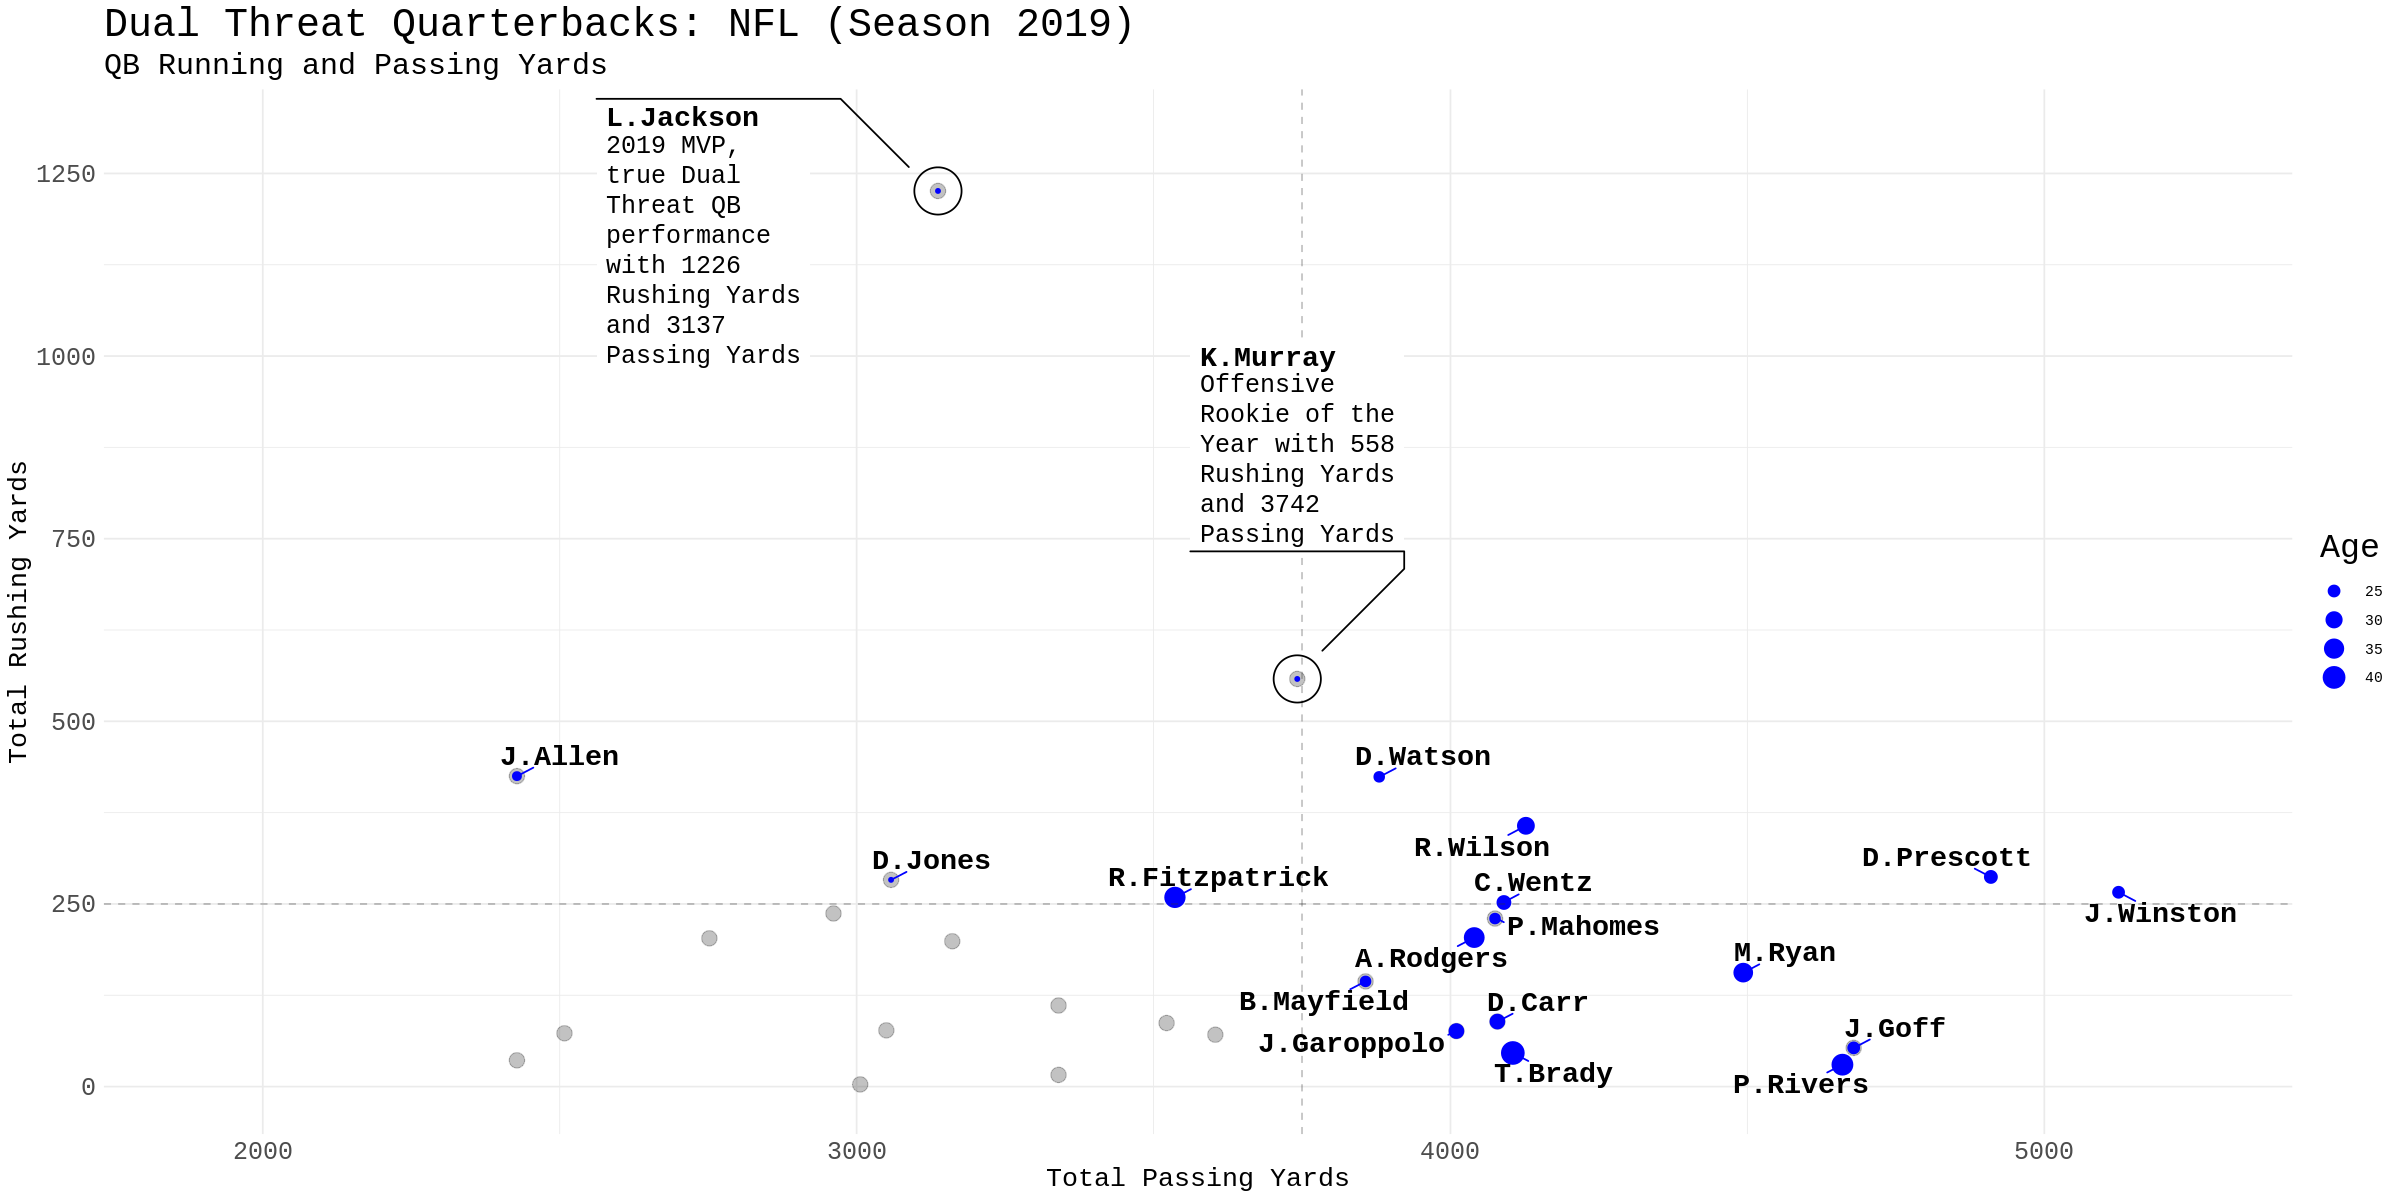

In [106]:
description_lamar <- "2019 MVP, true Dual Threat QB performance with 1226 Rushing Yards and 3137 Passing Yards"
description_kyler <- "Offensive Rookie of the Year with 558 Rushing Yards and 3742 Passing Yards"


options(repr.plot.width=20, repr.plot.height=10)

QB_joined2 %>%
  ggplot(aes(x= Total_Yards, y= Running_Yards)) +
  geom_point(data = QB_joined2 %>%
                      filter(Total_Yards < 3750 | Running_Yards < 250),
              color = "grey20", size = 4, alpha =0.3) +
  geom_point(data= QB_joined2 %>%
                      filter(Total_Yards > 3750 | Running_Yards > 250), color = "blue",
              aes( size= Age)) + 
  geom_hline(yintercept = 250, color= "grey20", linetype= "dashed", alpha= 0.3)+
  geom_vline(xintercept = 3750, color= "grey20", linetype= "dashed", alpha= 0.3)+
  geom_text_repel(data= QB_joined2 %>%
                  filter(Total_Yards > 3750 | Running_Yards > 250, !rusher_player_name %in% c("L.Jackson", "K.Murray")),
                  aes(label= rusher_player_name, family ="AvantGarde", fontface= "bold"),
              seed = 15, size = 6, min.segment.length= 0, segment.color = "blue", point.padding = 0.2) +
  geom_mark_circle(aes(filter= rusher_player_name == "L.Jackson", label = "L.Jackson", 
                              description = description_lamar), label.family ="AvantGarde", label.buffer = unit(20, "mm"), label.fontsize = c(17, 15))+
  geom_mark_circle(aes(filter= rusher_player_name == "K.Murray", label = "K.Murray", 
                              description = description_kyler), label.family ="AvantGarde", label.buffer = unit(20, "mm"), label.fontsize = c(17, 15))+

  scale_x_continuous(breaks = c(2000, 3000, 4000, 5000), limits = c(1900, 5250)) +
  scale_y_continuous(breaks = c(0, 250, 500, 750, 1000, 1250), limits= c(0, 1300))+
  labs(title= "Dual Threat Quarterbacks: NFL (Season 2019)",
        subtitle= "QB Running and Passing Yards",
        x= "Total Passing Yards",
        y= "Total Rushing Yards") +
  theme_minimal() +
  theme( text = element_text(family = "AvantGarde"),
        title= element_text(size= 20),
        plot.subtitle = element_text(size = 18),
        axis.title= element_text(size= 16),
        axis.text= element_text(size=15))

Warning message:
“Removed 19 rows containing missing values (geom_point).”


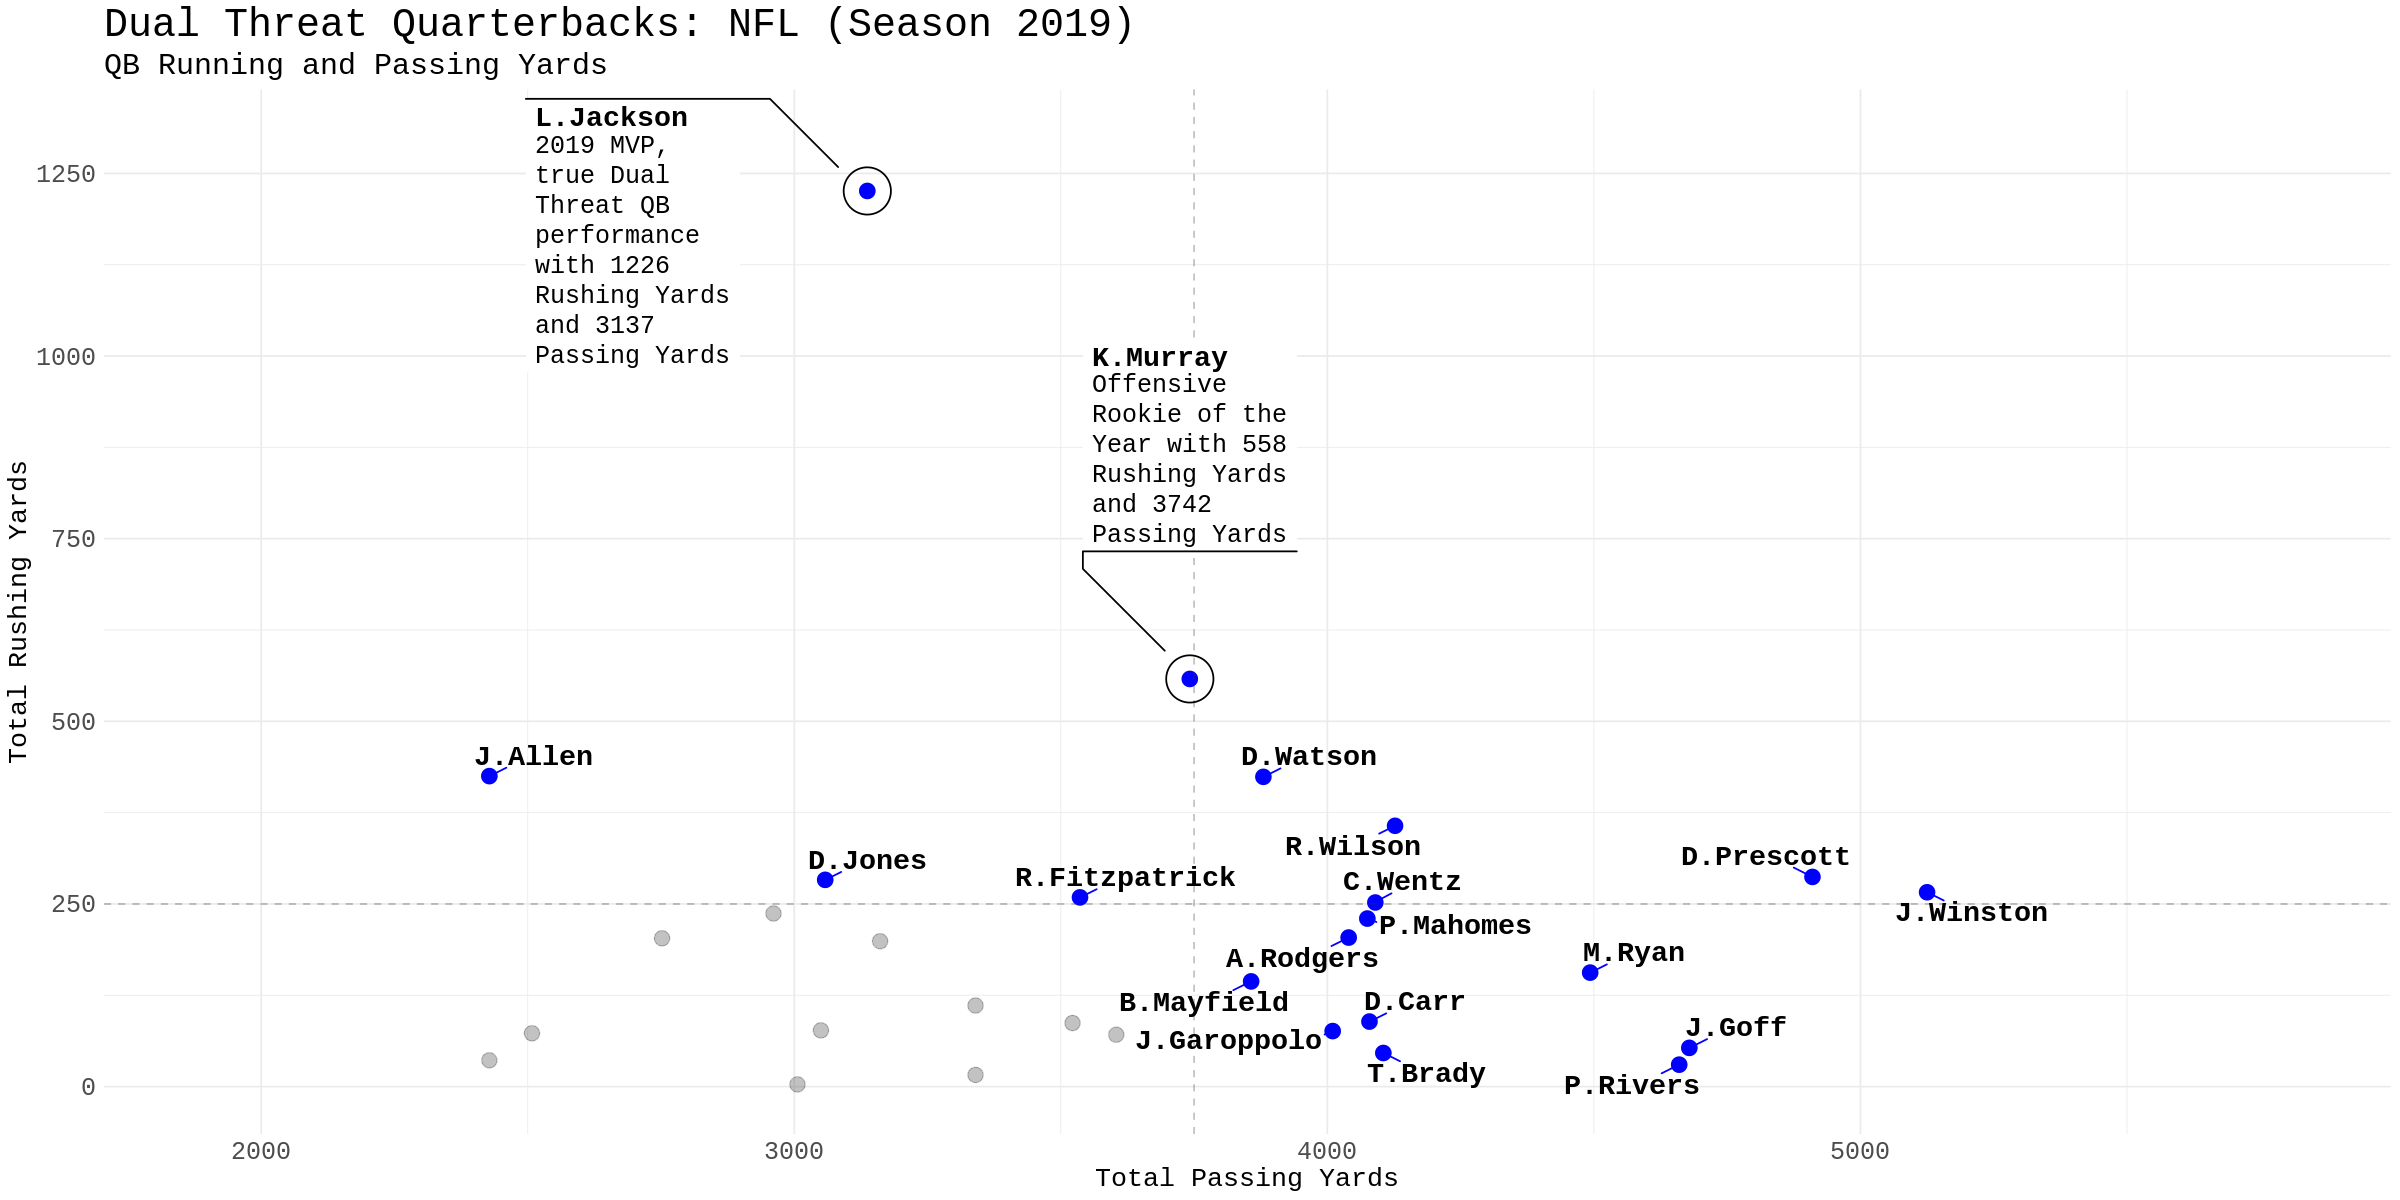

In [116]:
description_lamar <- "2019 MVP, true Dual Threat QB performance with 1226 Rushing Yards and 3137 Passing Yards"
description_kyler <- "Offensive Rookie of the Year with 558 Rushing Yards and 3742 Passing Yards"


options(repr.plot.width=20, repr.plot.height=10)

QB_joined2 %>%
  ggplot(aes(x= Total_Yards, y= Running_Yards)) +
  geom_point(data = QB_joined2 %>%
                      filter(Total_Yards < 3750 | Running_Yards < 250),
              color = "grey20", size = 4, alpha =0.3) +
  geom_point(data= QB_joined2 %>%
                      filter(Total_Yards > 3750 | Running_Yards > 250),
                       color = "blue", size= 4) + 
  geom_hline(yintercept = 250, color= "grey20", linetype= "dashed", alpha= 0.3)+
  geom_vline(xintercept = 3750, color= "grey20", linetype= "dashed", alpha= 0.3)+
  geom_text_repel(data= QB_joined2 %>%
                  filter(Total_Yards > 3750 | Running_Yards > 250, !rusher_player_name %in% c("L.Jackson", "K.Murray")),
                  aes(label= rusher_player_name, family ="AvantGarde", fontface= "bold"),
              seed = 15, size = 6, min.segment.length= 0, segment.color = "blue", point.padding = 0.2) +
  geom_mark_circle(aes(filter= rusher_player_name == "L.Jackson", label = "L.Jackson", 
                              description = description_lamar), label.family ="AvantGarde", label.buffer = unit(20, "mm"), label.fontsize = c(17, 15))+
  geom_mark_circle(aes(filter= rusher_player_name == "K.Murray", label = "K.Murray", 
                              description = description_kyler), label.family ="AvantGarde", label.buffer = unit(20, "mm"), label.fontsize = c(17, 15))+

  scale_x_continuous(breaks = c(2000, 3000, 4000, 5000), limits = c(1900, 5800)) +
  scale_y_continuous(breaks = c(0, 250, 500, 750, 1000, 1250), limits= c(0, 1300))+
  labs(title= "Dual Threat Quarterbacks: NFL (Season 2019)",
        subtitle= "QB Running and Passing Yards",
        x= "Total Passing Yards",
        y= "Total Rushing Yards") +
  theme_minimal() +
  theme( text = element_text(family = "AvantGarde"),
        title= element_text(size= 20),
        plot.subtitle = element_text(size = 18),
        axis.title= element_text(size= 16),
        axis.text= element_text(size=15)) -> QB_dual_threat
QB_dual_threat

* L.Jackson actually Rank 1 in Yards per Run and Rank 6 in overall Running Yards for all Running backs in the league

In [117]:
ggsave(plot = QB_dual_threat, "QB_Dual_Threat.png", height = 10, width = 20)

Warning message:
“Removed 19 rows containing missing values (geom_point).”


Warning message:
“Removed 18 rows containing missing values (geom_point).”


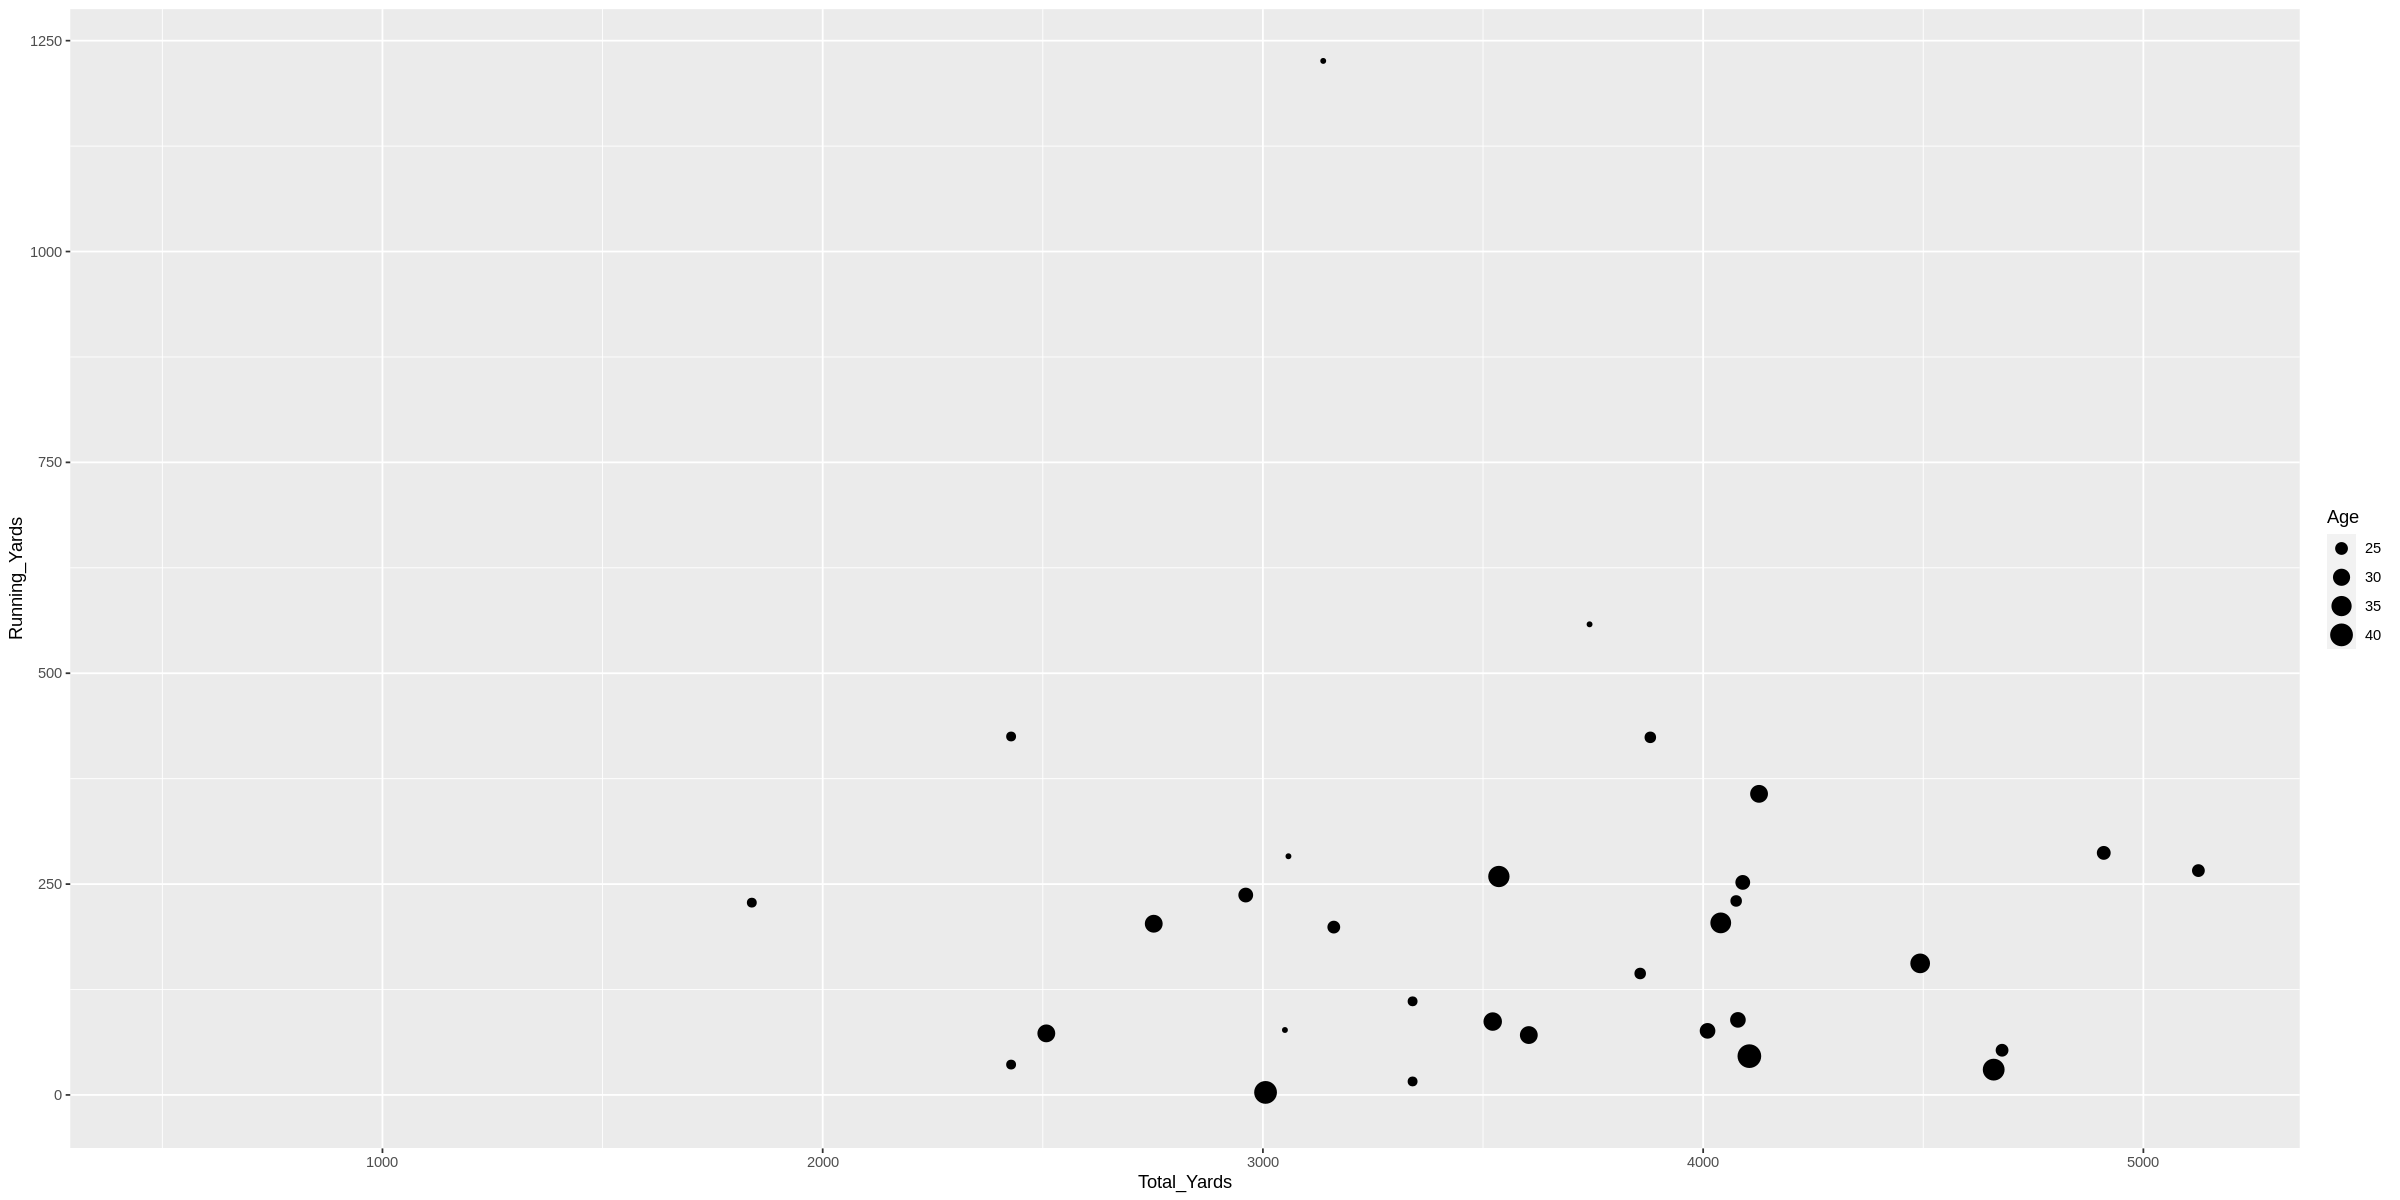

In [44]:
QB_joined2 %>%
ggplot(aes(x= Total_Yards, y= Running_Yards))+
geom_point(aes(size= Age))

In [ ]:
age <- read_csv2("/content/sportsref_download.xls.csv")
age %>%
select(Player, Age) -> age
age

In [35]:
QB_joined %>%
left_join(age, QB_joined, by= c("rusher_player_name" = "Player")) -> QB_joined2
QB_joined2

rusher_player_name,Running_Yards,posteam,Games_Played,Total_Passes,Completed_Passes,Incomplete_Passes,Completion_Rate,Total_Yards,Yards_per_Attempt,Yards_per_Completion,Average_EPA,Interceptions,Interception_Rate,TDs,TD_Rate,TDs_per_Interception,Age
<chr>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
L.Jackson,1226,BAL,15,401,263,128,65.6,3137,7.82,11.93,0.416,6,1.5,36,9.0,6.000,22
K.Murray,558,ARI,16,530,339,174,64.0,3742,7.06,11.04,0.160,11,2.1,23,4.3,2.091,22
J.Allen,425,BUF,13,357,208,137,58.3,2428,6.80,11.67,0.103,8,2.2,17,4.8,2.125,23
D.Watson,424,HOU,15,486,324,146,66.7,3880,7.98,11.98,0.309,11,2.3,27,5.6,2.455,24
R.Wilson,357,SEA,16,513,334,166,65.1,4127,8.04,12.36,0.291,5,1.0,34,6.6,6.800,31
D.Prescott,287,DAL,16,585,380,194,65.0,4910,8.39,12.92,0.306,9,1.5,30,5.1,3.333,26
D.Jones,283,NYG,13,450,270,163,60.0,3058,6.80,11.33,0.137,12,2.7,24,5.3,2.000,22
J.Winston,266,TB,16,616,375,208,60.9,5125,8.32,13.67,0.229,28,4.5,40,6.5,1.429,25
R.Fitzpatrick,259,MIA,15,495,301,175,60.8,3536,7.14,11.75,0.153,12,2.4,22,4.4,1.833,37


`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 18 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 18 rows containing missing values (geom_point).”


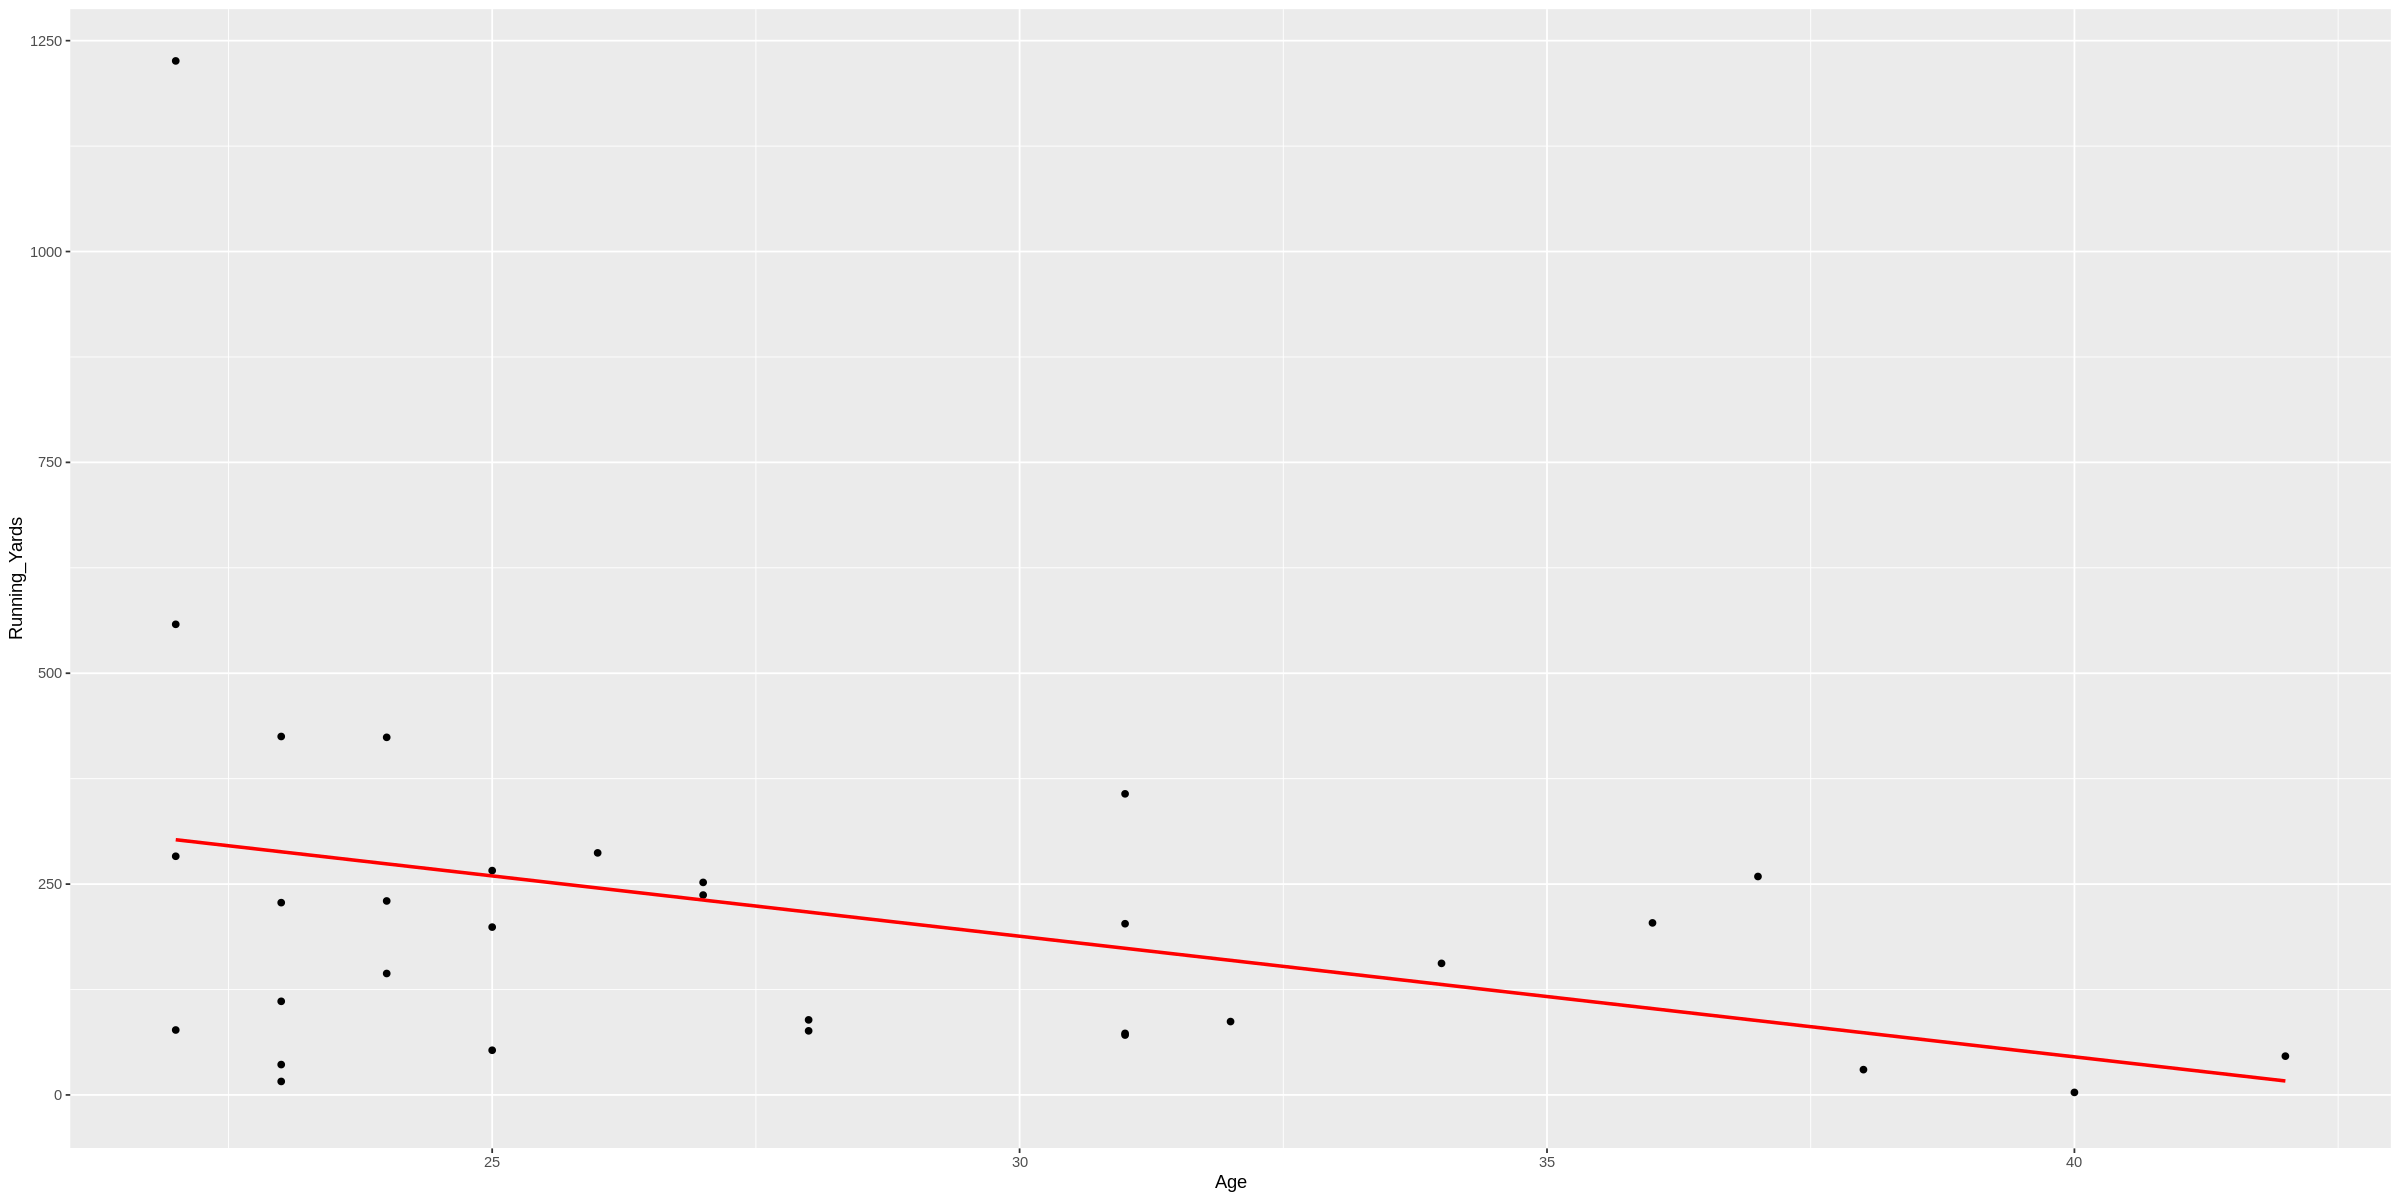

In [29]:
QB_joined2 %>%
ggplot(aes(x= Age, y= Running_Yards)) +
geom_point() +
geom_smooth(method=lm , color="red", se=FALSE)

In [108]:
saveRDS(QB_joined2, file="QB_joined.rds")

In [19]:
pbp_all_rp %>%
names()

[1] "play_id"                             
  [2] "game_id"                             
  [3] "home_team"                           
  [4] "away_team"                           
  [5] "posteam"                             
  [6] "posteam_type"                        
  [7] "defteam"                             
  [8] "side_of_field"                       
  [9] "yardline_100"                        
 [10] "game_date"                           
 [11] "quarter_seconds_remaining"           
 [12] "half_seconds_remaining"              
 [13] "game_seconds_remaining"              
 [14] "game_half"                           
 [15] "quarter_end"                         
 [16] "drive"                               
 [17] "sp"                                  
 [18] "qtr"                                 
 [19] "down"                                
 [20] "goal_to_go"                          
 [21] "time"                                
 [22] "yrdln"                               
 [23] "ydstogo"                             
 [24] "ydsnet"                              
 [25] "desc"                                
 [26] "play_type"                           
 [27] "yards_gained"                        
 [28] "shotgun"                             
 [29] "no_huddle"                           
 [30] "qb_dropback"                         
 [31] "qb_kneel"                            
 [32] "qb_spike"                            
 [33] "qb_scramble"                         
 [34] "pass_length"                         
 [35] "pass_location"                       
 [36] "air_yards"                           
 [37] "yards_after_catch"                   
 [38] "run_location"                        
 [39] "run_gap"                             
 [40] "field_goal_result"                   
 [41] "kick_distance"                       
 [42] "extra_point_result"                  
 [43] "two_point_conv_result"               
 [44] "home_timeouts_remaining"             
 [45] "away_timeouts_remaining"             
 [46] "timeout"                             
 [47] "timeout_team"                        
 [48] "td_team"                             
 [49] "posteam_timeouts_remaining"          
 [50] "defteam_timeouts_remaining"          
 [51] "total_home_score"                    
 [52] "total_away_score"                    
 [53] "posteam_score"                       
 [54] "defteam_score"                       
 [55] "score_differential"                  
 [56] "posteam_score_post"                  
 [57] "defteam_score_post"                  
 [58] "score_differential_post"             
 [59] "no_score_prob"                       
 [60] "opp_fg_prob"                         
 [61] "opp_safety_prob"                     
 [62] "opp_td_prob"                         
 [63] "fg_prob"                             
 [64] "safety_prob"                         
 [65] "td_prob"                             
 [66] "extra_point_prob"                    
 [67] "two_point_conversion_prob"           
 [68] "ep"                                  
 [69] "epa"                                 
 [70] "total_home_epa"                      
 [71] "total_away_epa"                      
 [72] "total_home_rush_epa"                 
 [73] "total_away_rush_epa"                 
 [74] "total_home_pass_epa"                 
 [75] "total_away_pass_epa"                 
 [76] "air_epa"                             
 [77] "yac_epa"                             
 [78] "comp_air_epa"                        
 [79] "comp_yac_epa"                        
 [80] "total_home_comp_air_epa"             
 [81] "total_away_comp_air_epa"             
 [82] "total_home_comp_yac_epa"             
 [83] "total_away_comp_yac_epa"             
 [84] "total_home_raw_air_epa"              
 [85] "total_away_raw_air_epa"              
 [86] "total_home_raw_yac_epa"              
 [87] "total_away_raw_yac_epa"              
 [88] "wp"                                  
 [89] "def_wp"                            

In [66]:
pbp_all_rp %>%
  filter(rush_attempt == 1, season == 2019) %>%
  group_by(rusher_player_name, posteam) %>%
  summarise(Games_Played = n_distinct(game_date),
              Rush_Attempts = sum(rush_attempt),
              Total_Yards = sum(yards_gained),
              Touchdowns = sum(touchdown),
              Average_Yards = round(mean(yards_gained), 2),
              Average_EPA = round(mean(epa),2),
              Fumbles = sum(fumble)) %>%
filter(Rush_Attempts > 100, rusher_player_name != "L.Jackson") %>%
arrange(-Total_Yards) -> RB_data
RB_data

`summarise()` regrouping output by 'rusher_player_name' (override with `.groups` argument)



rusher_player_name,posteam,Games_Played,Rush_Attempts,Total_Yards,Touchdowns,Average_Yards,Average_EPA,Fumbles
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
D.Henry,TEN,15,303,1540,16,5.08,0.03,5
N.Chubb,CLE,16,298,1494,9,5.01,-0.04,2
C.McCaffrey,CAR,16,287,1388,15,4.84,0.02,1
E.Elliott,DAL,16,301,1357,12,4.51,0.05,3
C.Carson,SEA,15,278,1230,8,4.42,-0.04,6
L.Fournette,JAC,15,266,1152,3,4.33,-0.06,0
J.Jacobs,OAK,13,241,1145,7,4.75,0.01,1
J.Mixon,CIN,16,278,1137,5,4.09,-0.05,0
D.Cook,MIN,14,250,1135,13,4.54,0.06,3


* Drop David Johnson because he seems to have wrong stats

In [64]:
pbp_all_rp %>%
filter(season == 2019, receiver_player_name %in% RB_data$rusher_player_name, play_type == "pass") %>%
group_by(receiver_player_name) %>%
summarise(Total_Catches= n(),
            Receiving_Yards = sum(yards_gained),
            Receiving_TDs= sum(touchdown),
            Yard_per_Catch = round(mean(yards_gained),2),
            Average_Catch_EPA = round(mean(epa), 2)) %>%
filter(receiver_player_name != "D.Johnson") %>%
arrange(-Receiving_Yards) -> RB_catch_data
RB_catch_data

`summarise()` ungrouping output (override with `.groups` argument)



receiver_player_name,Total_Catches,Receiving_Yards,Receiving_TDs,Yard_per_Catch,Average_Catch_EPA
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
C.McCaffrey,142,1005,4,7.08,0.38
A.Ekeler,108,993,8,9.19,0.41
A.Kamara,97,533,1,5.49,0.12
L.Fournette,100,521,0,5.21,-0.19
D.Cook,63,519,0,8.24,0.43
M.Sanders,63,509,3,8.08,0.32
A.Jones,68,474,3,6.97,0.15
L.Bell,78,463,1,5.94,0.15
S.Barkley,73,438,2,6.00,0.04


In [69]:
pbp_all_rp %>%
filter(season == 2019, play_type == "run" | play_type == "pass", !is.na(epa)) %>%
group_by(posteam) %>%
summarise(Rushing_Yards_team = sum(yards_gained[play_type == "run"]),
          Receiving_Yards_team = sum(yards_gained[play_type== "pass"]),
          Total_Yards_team = sum(Rushing_Yards_team + Receiving_Yards_team)) -> Team_Yards
Team_Yards

`summarise()` ungrouping output (override with `.groups` argument)



posteam,Rushing_Yards_team,Receiving_Yards_team,Total_Yards_team
<chr>,<dbl>,<dbl>,<dbl>
ARI,2006,3494,5500
ATL,1373,4707,6080
BAL,3317,3225,6542
BUF,2054,3233,5287
CAR,1825,3650,5475
CHI,1464,3289,4753
CIN,1531,3645,5176
CLE,1897,3554,5451
DAL,2165,4740,6905


In [67]:
RB_data %>%
left_join(RB_catch_data, RB_data, by= c("rusher_player_name" = "receiver_player_name")) -> RB_joined
RB_joined

rusher_player_name,posteam,Games_Played,Rush_Attempts,Total_Yards,Touchdowns,Average_Yards,Average_EPA,Fumbles,Total_Catches,Receiving_Yards,Receiving_TDs,Yard_per_Catch,Average_Catch_EPA
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
D.Henry,TEN,15,303,1540,16,5.08,0.03,5,24,206,2,8.58,0.29
N.Chubb,CLE,16,298,1494,9,5.01,-0.04,2,49,278,0,5.67,-0.07
C.McCaffrey,CAR,16,287,1388,15,4.84,0.02,1,142,1005,4,7.08,0.38
E.Elliott,DAL,16,301,1357,12,4.51,0.05,3,71,420,2,5.92,0.08
C.Carson,SEA,15,278,1230,8,4.42,-0.04,6,46,266,2,5.78,0.14
L.Fournette,JAC,15,266,1152,3,4.33,-0.06,0,100,521,0,5.21,-0.19
J.Jacobs,OAK,13,241,1145,7,4.75,0.01,1,27,166,0,6.15,0.21
J.Mixon,CIN,16,278,1137,5,4.09,-0.05,0,45,287,3,6.38,0.19
D.Cook,MIN,14,250,1135,13,4.54,0.06,3,63,519,0,8.24,0.43


In [70]:
RB_joined %>%
left_join(Team_Yards, RB_joined, by = "posteam") -> RB_joined2
RB_joined2

rusher_player_name,posteam,Games_Played,Rush_Attempts,Total_Yards,Touchdowns,Average_Yards,Average_EPA,Fumbles,Total_Catches,Receiving_Yards,Receiving_TDs,Yard_per_Catch,Average_Catch_EPA,Rushing_Yards_team,Receiving_Yards_team,Total_Yards_team
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
D.Henry,TEN,15,303,1540,16,5.08,0.03,5,24,206,2,8.58,0.29,2242,3560,5802
N.Chubb,CLE,16,298,1494,9,5.01,-0.04,2,49,278,0,5.67,-0.07,1897,3554,5451
C.McCaffrey,CAR,16,287,1388,15,4.84,0.02,1,142,1005,4,7.08,0.38,1825,3650,5475
E.Elliott,DAL,16,301,1357,12,4.51,0.05,3,71,420,2,5.92,0.08,2165,4740,6905
C.Carson,SEA,15,278,1230,8,4.42,-0.04,6,46,266,2,5.78,0.14,2215,3793,6008
L.Fournette,JAC,15,266,1152,3,4.33,-0.06,0,100,521,0,5.21,-0.19,1720,3768,5488
J.Jacobs,OAK,13,241,1145,7,4.75,0.01,1,27,166,0,6.15,0.21,1886,3926,5812
J.Mixon,CIN,16,278,1137,5,4.09,-0.05,0,45,287,3,6.38,0.19,1531,3645,5176
D.Cook,MIN,14,250,1135,13,4.54,0.06,3,63,519,0,8.24,0.43,2146,3502,5648


In [73]:
RB_joined2 %>%
group_by(rusher_player_name, posteam) %>%
mutate(rush_contribution = Total_Yards/Rushing_Yards_team,
        rec_contribution = Receiving_Yards/Receiving_Yards_team) -> RB_plot
RB_plot

rusher_player_name,posteam,Games_Played,Rush_Attempts,Total_Yards,Touchdowns,Average_Yards,Average_EPA,Fumbles,Total_Catches,Receiving_Yards,Receiving_TDs,Yard_per_Catch,Average_Catch_EPA,Rushing_Yards_team,Receiving_Yards_team,Total_Yards_team,rush_contribution,rec_contribution
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
D.Henry,TEN,15,303,1540,16,5.08,0.03,5,24,206,2,8.58,0.29,2242,3560,5802,0.6868867,0.05786517
N.Chubb,CLE,16,298,1494,9,5.01,-0.04,2,49,278,0,5.67,-0.07,1897,3554,5451,0.7875593,0.07822172
C.McCaffrey,CAR,16,287,1388,15,4.84,0.02,1,142,1005,4,7.08,0.38,1825,3650,5475,0.7605479,0.27534247
E.Elliott,DAL,16,301,1357,12,4.51,0.05,3,71,420,2,5.92,0.08,2165,4740,6905,0.6267898,0.08860759
C.Carson,SEA,15,278,1230,8,4.42,-0.04,6,46,266,2,5.78,0.14,2215,3793,6008,0.5553047,0.07012919
L.Fournette,JAC,15,266,1152,3,4.33,-0.06,0,100,521,0,5.21,-0.19,1720,3768,5488,0.6697674,0.13826964
J.Jacobs,OAK,13,241,1145,7,4.75,0.01,1,27,166,0,6.15,0.21,1886,3926,5812,0.6071050,0.04228222
J.Mixon,CIN,16,278,1137,5,4.09,-0.05,0,45,287,3,6.38,0.19,1531,3645,5176,0.7426519,0.07873800
D.Cook,MIN,14,250,1135,13,4.54,0.06,3,63,519,0,8.24,0.43,2146,3502,5648,0.5288910,0.14820103


In [8]:
#saveRDS(RB_plot, file="RB_plot.rds")
RB_plot <- readRDS("RB_plot.rds")

Warning message:
“Removed 11 rows containing missing values (geom_point).”


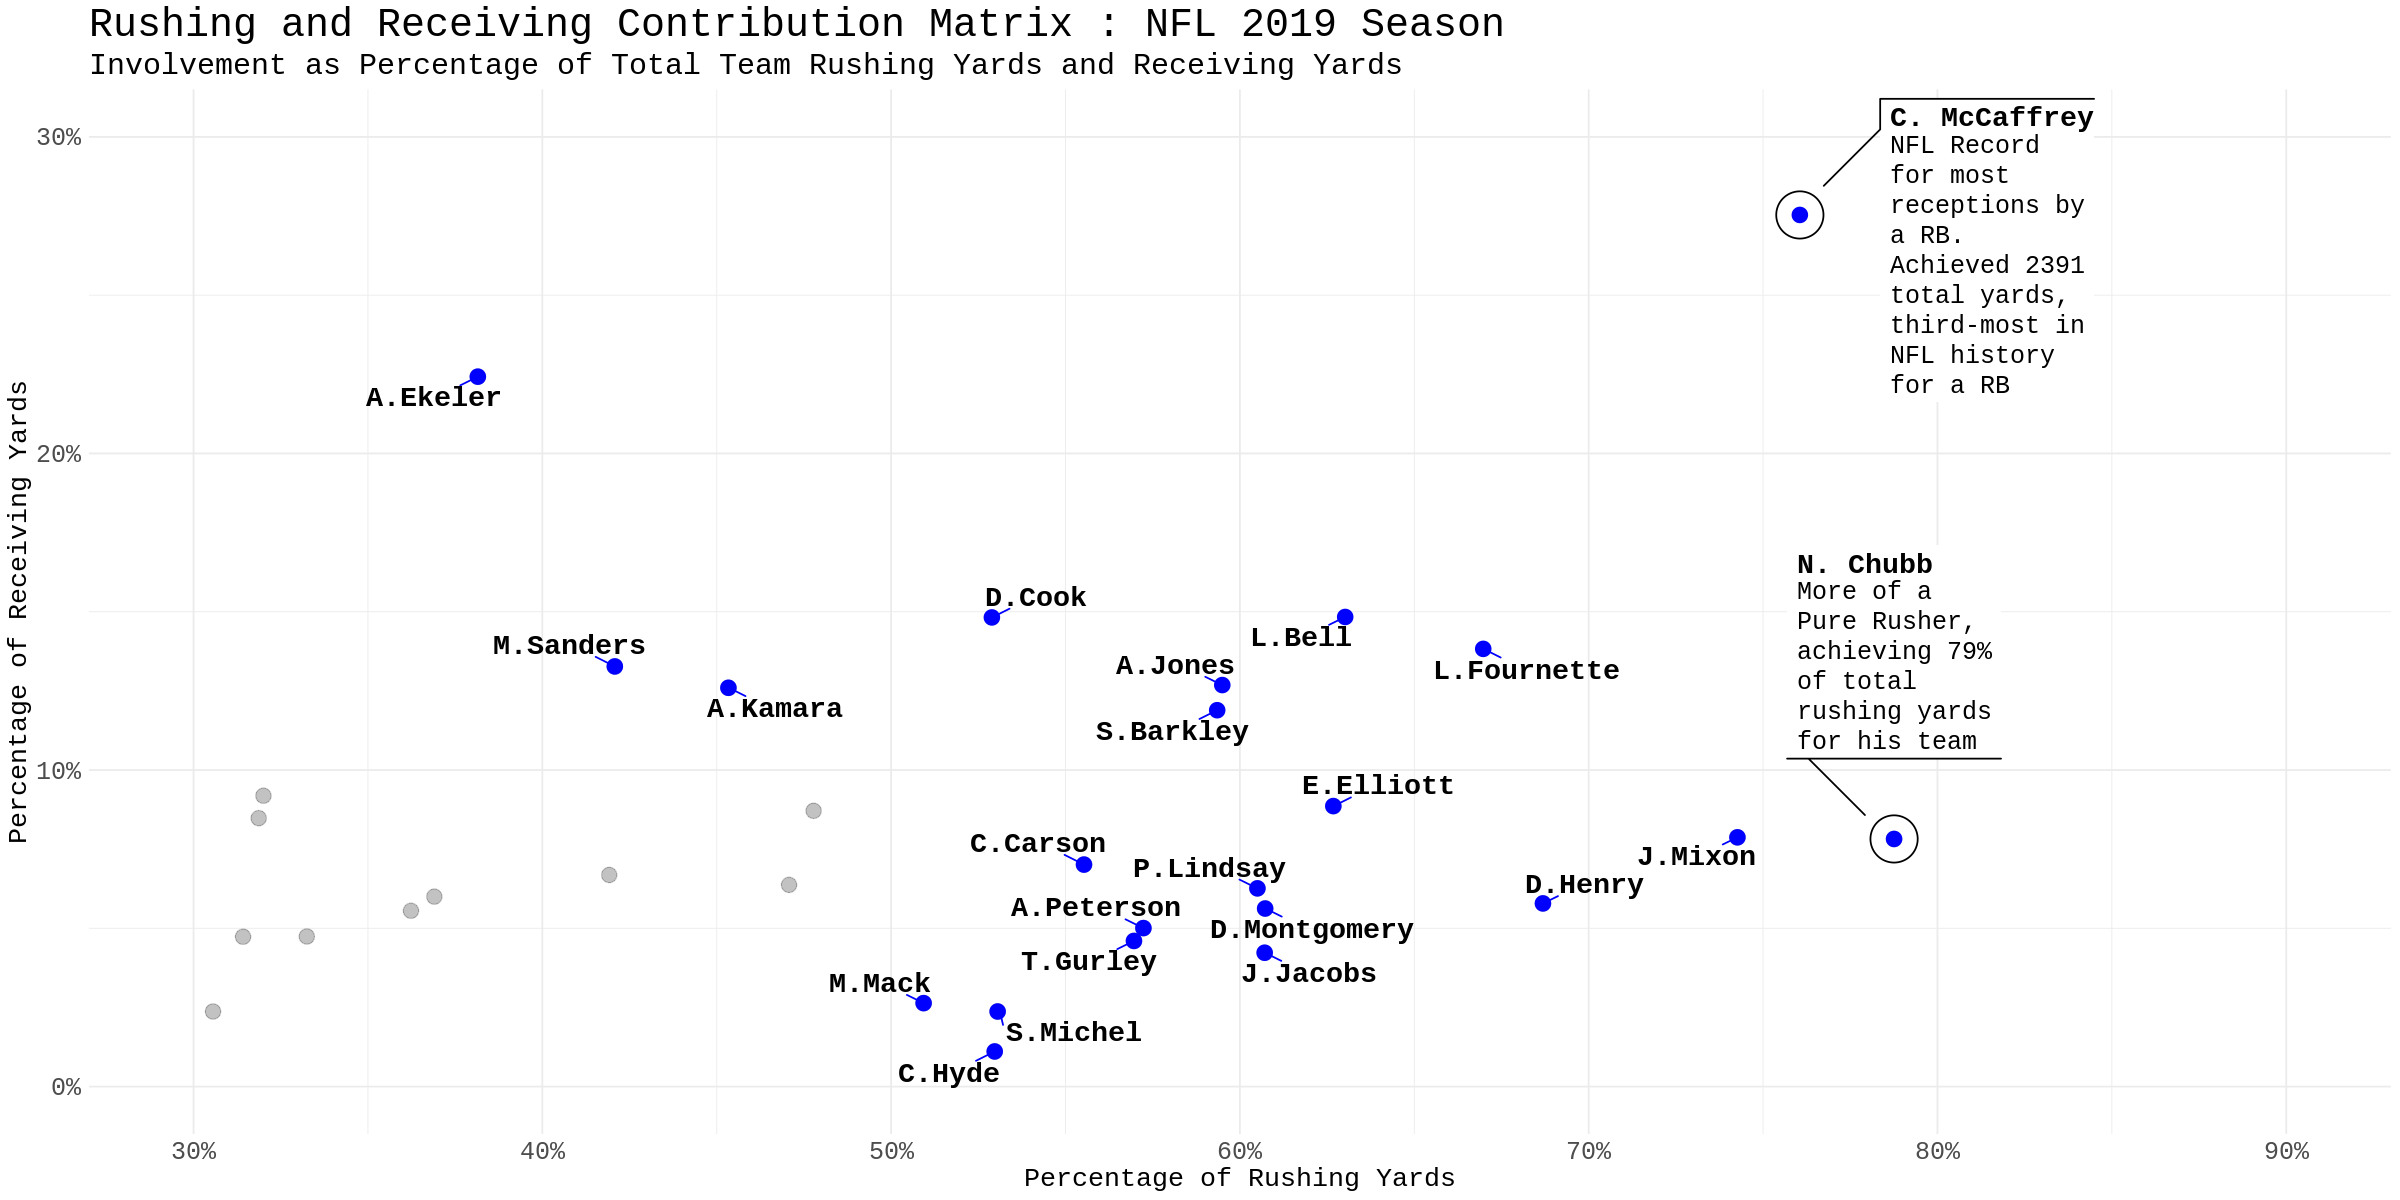

In [17]:
options(repr.plot.width=20, repr.plot.height=10)

desc_cmc <- "NFL Record for most receptions by a RB. Achieved 2391 total yards, third-most in NFL history for a RB "
desc_chubb <- "More of a Pure Rusher, achieving 79% of total rushing yards for his team"

RB_plot %>%
  ggplot(aes(x= rush_contribution, y= rec_contribution)) +
  geom_point(data = RB_plot %>%
              filter(rush_contribution < 0.5 | rec_contribution < 0.1),
              color= "grey20", size=4, alpha = 0.3) +
  geom_point(data= RB_plot %>%
              filter(rush_contribution > 0.5 | rec_contribution > 0.1),
              color= "blue", size = 4) +
  geom_text_repel(data = RB_plot %>%
                  filter(rush_contribution > 0.5 | rec_contribution > 0.1,
                  !rusher_player_name %in% c("C.McCaffrey", "N.Chubb")),
                  aes(label = rusher_player_name, family= "AvantGarde", fontface= "bold"),
                  seed = 15, size = 6, min.segment.length= 0, segment.color = "blue", point.padding = 0.2) +
  geom_mark_circle(aes(filter = rusher_player_name == "C.McCaffrey", label= "C. McCaffrey",
                        description = desc_cmc),
                        label.family = "AvantGarde", label.fontsize = c(17,15))+
    geom_mark_circle(aes(filter = rusher_player_name == "N.Chubb", label= "N. Chubb",
                        description = desc_chubb),
                        label.family = "AvantGarde", label.fontsize = c(17,15))+

  scale_x_continuous(labels = percent_format(accuracy = 1),
                      breaks = c(0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9),
                      limits = c(0.3, 0.9)) +
  scale_y_continuous(labels = percent_format(accuracy = 1),
                      limits = c(0, 0.3)) +
  labs(title = "Rushing and Receiving Contribution Matrix : NFL 2019 Season",
        subtitle = "Involvement as Percentage of Total Team Rushing Yards and Receiving Yards",
        x = "Percentage of Rushing Yards",
        y = "Percentage of Receiving Yards")+

  theme_minimal() +
  theme( text = element_text(family = "AvantGarde"),
        title= element_text(size= 20),
        plot.subtitle = element_text(size = 18),
        axis.title= element_text(size= 16),
        axis.text= element_text(size=15))

In [25]:
install.packages("ggalluvial")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [26]:
library(ggalluvial)

In [27]:
pbp_all_rp %>%
filter(season == 2019, passer_player_name == "P.Mahomes", !is.na(receiver_player_name)) %>%
select(passer_player_name ,receiver_player_name, desc) %>%
count(receiver_player_name, passer_player_name) -> KC_alu
KC_alu


receiver_player_name,passer_player_name,n
<chr>,<chr>,<int>
A.Sherman,P.Mahomes,3
B.Bell,P.Mahomes,12
B.Pringle,P.Mahomes,18
D.Robinson,P.Mahomes,53
D.Thomas,P.Mahomes,2
D.Thompson,P.Mahomes,10
D.Williams,P.Mahomes,18
D.Yelder,P.Mahomes,5
Dam.Williams,P.Mahomes,39


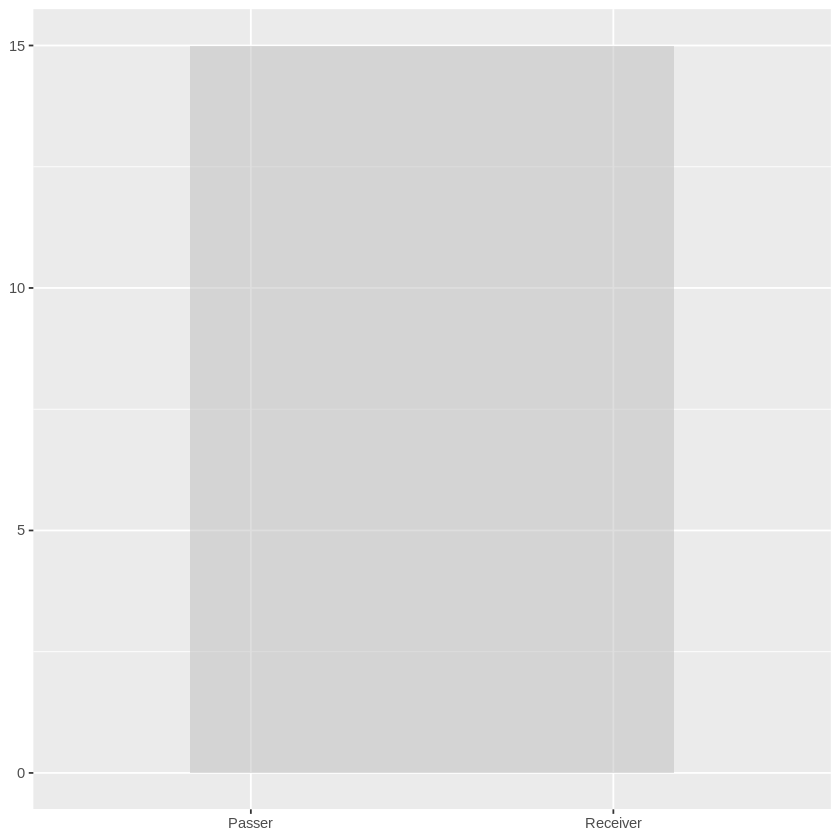

In [33]:
ggplot( data= KC_alu,
          aes( axis1 = passer_player_name, axis2 = receiver_player_name, weight= n))+
    geom_alluvium()+
    scale_x_discrete( limits= c("Passer", "Receiver"))

In [ ]:
nodes = data.frame("name" =
  c("P.Mahomes", "A.Sherman", "B.Bell", "B.Pringle", "D.Robinson", "D.Thomas", "D.Thompson", "D.Williams",
      "D.Yelder", "Dam.Williams", "L.McCoy", "M.Hardman","S.Ware", "S.Watkins","T.Hill", "T.Kelce"))
nodes

In [20]:
links= as.data.frame(matrix(c(
  0, 1, 3,
  0, 2, 12,
  0, 3, 18,
  0, 4, 53,
  0, 5, 2,
  0, 6, 10,
  0, 7, 18,
  0, 8, 5,
  0, 9, 39,
  0, 10, 29,
  0, 11, 43,
  0, 12, 8,
  0, 13, 79,
  0, 14, 68,
  0, 15, 128), byrow= TRUE, ncol= 3))
  names(links) = c("source", "target", "value")

In [23]:
sankeyNetwork(Links = links, Nodes = nodes, Source= "source", Target= "target",
              Value = "value", NodeID = "name", 
              fontSize = 12, nodeWidth = 30)

HTML widgets cannot be represented in plain text (need html)